In [1]:
%reload_ext watermark
%matplotlib inline

import os
from scipy.stats import mannwhitneyu
from contextlib import suppress
from metapool.metapool import *
from metapool.util import (
    join_dfs_from_files, extend_sample_accession_df,
    extend_compression_layout_info, QIITA_STUDY_ID_KEY)
from metapool.plate import PlateReplication, record_gdna_dilution
from metapool import (make_sample_sheet, 
                      find_threshold, autopool, add_controls, compress_plates, 
                      TUBECODE_KEY, SAMPLE_NAME_KEY, SAMPLE_DNA_CONC_KEY, 
                      NORMALIZED_DNA_VOL_KEY, SYNDNA_POOL_NUM_KEY
                      )
from metapool.mp_strings import PM_SAMPLE_KEY
from metapool.sample_sheet import (
    TELLSEQ_METAG_SHEET_TYPE, TELLSEQ_ABSQUANT_SHEET_TYPE, make_sections_dict)
%watermark -i -v -iv -m -h -p metapool,sample_sheet,openpyxl -u

Last updated: 2024-11-19T16:44:38.227712-08:00

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.12.0

metapool    : 0+untagged.221.gd899203
sample_sheet: 0.13.0
openpyxl    : 3.1.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.0.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Hostname: C02G21EEMD6Q

re        : 2.2.1
numpy     : 2.0.0
pandas    : 2.2.2
seaborn   : 0.13.2
json      : 2.0.9
matplotlib: 3.9.0



In [2]:
! conda list

# packages in environment at /Applications/miniconda3/envs/metapool:
#
# Name                    Version                   Build  Channel
anyio                     4.4.0              pyhd8ed1ab_0    conda-forge
appnope                   0.1.4              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hdc70f33_4    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1              pyhd8ed1ab_0    conda-forge
async-lru                 2.0.4              pyhd8ed1ab_0    conda-forge
attrs                     23.2.0             pyh71513ae_0    conda-forge
babel                     2.14.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
beautifulsoup4            4.12.3             pyha770c72_0    conda-forge
biom-format               2.1.16                   pypi_0  

# Knight Lab TellSeq pipeline notebook

## Part 1 (of 4): Workflow for normalizing DNA

This portion of the notebook will read in the output of the mini-Pico quantification assay and construct an Echo normalization picklist file. 

As inputs, it requires:
1. A tab-delimited row-wise sample accession file that indicates the sample name (`sample_name`) and its associated matrix tube barcode (`TubeCode`)
2. A tab-delimited metadata file downloaded from Qiita
3. An accurate plate compression form, with appropriate VisionMate barcode scanner files (`Plate map file`)
4. **TWO** DNA concentration files: one for the undiluted plate and one for the 1:10 dilution plate

The workflow then:
1. reads in the specified input files and constructs a dataframe
2. calculates volumes to be added via echo to reach desired input DNA quantity, with info on which samples need to be pulled from the diluted plate and which from the original plate
3. produces an Echo-formatted pick list file

### Part 1 of 4, Step 0 of 8: Provide inputs

In [3]:
expt_name = "RKL4982"

In [4]:
# One dictionary per study included in the samples on this run.
studies_info = [
    # EVERY entry in the dictionary must be specifically updated 
    # *every* time this notebook is run--none of these have defaults!
    {
    'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
    'Project Abbreviation': 'ADAPT', # PROJECTNAME
    'sample_accession_fp': './test_data/Plate_Maps/sa_file_1.tsv',
    'qiita_metadata_fp': './test_data/Plate_Maps/12986_20230314-090655.txt',
    'experiment_design_description': 'isolate sequencing',
    'HumanFiltering': 'False', 
    'Email': 'r@gmail.com'
    },
    {
    'Project Name': 'CHILD_15510', # PROJECTNAME_QIITAID
    'Project Abbreviation': 'CHILD', # PROJECTNAME
    'sample_accession_fp': './test_data/Plate_Maps/sa_file_2.tsv',
    'qiita_metadata_fp': './test_data/Plate_Maps/15510_20240503-090339.txt',
    'experiment_design_description': 'whole genome sequencing',
    'HumanFiltering': 'True',
    'Email': 'l@ucsd.edu'
    },
    {
    'Project Name': 'Celeste_Marmoset_14577', # PROJECTNAME_QIITAID
    'Project Abbreviation': 'MARMO', # PROJECTNAME
    'sample_accession_fp': './test_data/Plate_Maps/sa_file_3.tsv',
    'qiita_metadata_fp': './test_data/Plate_Maps/14577_20230711-082202.txt',
    'experiment_design_description': 'whole genome sequencing',
    'HumanFiltering': 'False',
    'Email': 'c@ucsd.edu'
    }
]

In [5]:
# TODO: ask what you put in here when doing replicates
compression_layout = [
    {
        # top left plate
        'Plate Position': 1, # as int
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_16_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_16', # Plate_#
        'Plate elution volume': 70
    },
    {
        # top right plate
        'Plate Position': 2, # as int
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_17_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_17', # Plate_#
        'Plate elution volume': 70
    },
    {
        # bottom left plate
        'Plate Position': 3, # as int
        'Plate map file': './test_data/Plate_Maps/2022_summer_Celeste_Adaptation_18_plate_map.tsv',
        'Project Name': 'Celeste_Adaptation_12986', # PROJECTNAME_QIITAID
        'Project Plate': 'Plate_18', # Plate_#
        'Plate elution volume': 70
    },
    {
        # bottom right plate
        'Plate Position': 4, # as int
        'Plate map file': './test_data/Plate_Maps/CHILD_1000_plate_map.tsv',
        'Project Name': 'CHILD_15510', # PROJECTNAME_QIITAID    
        'Project Plate': 'Plate_1000',  # Plate_#
        'Plate elution volume': 70
    },
]

In [6]:
# CONSTANTS: Users, DO NOT CHANGE THESE
# values without consulting with tech team
SHEET_TYPE_VERSIONS = {
    TELLSEQ_METAG_SHEET_TYPE: '10',  # version supporting SampleContext
    TELLSEQ_ABSQUANT_SHEET_TYPE: '10'
}

BIOINFO_BASE = {
    'ForwardAdapter': 'GATCGGAAGAGCACACGTCTGAACTCCAGTCAC',
    'ReverseAdapter': 'GATCGGAAGAGCGTCGTGTAGGGAAAGGAGTGT',
    'library_construction_protocol': 'Knight Lab Kapa HyperPlus',
    # The BarcodesAreRC value is no longer used, but is still checked for
    # by the validation while making the sample sheet, so put in a dummy value
    'BarcodesAreRC': 'True'
}

WELL_COL = 'Well'
LIB_WELL_COL = 'Library Well'

# Mask arrays for even and odd rows and columns
EVEN_ROWS = [x for x in range(16) if x % 2 == 0]
ODD_ROWS = [x for x in range(16) if x % 2 == 1]
EVEN_COLS = [x for x in range(24) if x % 2 == 0]
ODD_COLS = [x for x in range(24) if x % 2 == 1]

In [7]:
def get_studies_attr_list(studies_dict, desired_key):
    return [x[desired_key] for x in studies_dict]

def pick_expected_separator(fps_list):
    sep = "\t"
    visible_sep = "tab"
    
    num_fps = len(fps_list)
    num_csv = sum([x.endswith('.csv') for x in fps_list])
    num_txt = sum([x.endswith('.txt') for x in fps_list])
    num_tsv = sum([x.endswith('.tsv') for x in fps_list])
    
    if num_csv == num_fps:
        sep = ','
        visible_sep = "comma"
    elif (num_tsv + num_txt) != num_fps:
        warnings.warn(
            "Could not determine separator; defaulting to " + visible_sep)

    return sep, visible_sep

### Part 1 of 4, Step 1 of 8: Read in sample accession files

In [8]:
# read in the sample accession files
sample_accession_fps = get_studies_attr_list(
    studies_info, 'sample_accession_fp')
sample_acc_sep, sa_sep_name = pick_expected_separator(sample_accession_fps)
print(f"Expected sample accession separator: {sa_sep_name}")

Expected sample accession separator: tab


In [9]:
sample_accession_df = join_dfs_from_files(
    sample_accession_fps, [SAMPLE_NAME_KEY, TUBECODE_KEY], sep=sample_acc_sep)
sample_accession_df.shape

(3941, 2)

In [10]:
sample_accession_df.head()

,sample_name,TubeCode
0,23B.Day7.1,0359097394
1,23B.Day7.10,0359097402
2,23B.Day7.11,0359097385
3,23B.Day7.12,0359097375
4,23B.Day7.13,0359098882


### Part 1 of 4, Step 2 of 8: Read in the sample info from Qiita

In [11]:
# read in the qiita metadata files
qiita_metadata_fps = get_studies_attr_list(studies_info, 'qiita_metadata_fp')
qiita_metadata_sep, qm_sep_name = pick_expected_separator(qiita_metadata_fps)
print(f"Expected qiita metadata separator: {qm_sep_name}")

Expected qiita metadata separator: tab


In [12]:
metadata_df = join_dfs_from_files(
    qiita_metadata_fps, [SAMPLE_NAME_KEY, QIITA_STUDY_ID_KEY], 
    opt_cols_to_extract=['tube_id'], unique_cols=[SAMPLE_NAME_KEY],
    sep=qiita_metadata_sep)
metadata_df.shape

(8161, 3)

In [13]:

metadata_df.head()

,sample_name,qiita_study_id,tube_id
0,12986.23B.Day7.1,12986,23b-1_day7
1,12986.23B.Day7.10,12986,23b-10_day7
2,12986.23B.Day7.11,12986,23b-11_day7
3,12986.23B.Day7.12,12986,23b-12_day7
4,12986.23B.Day7.13,12986,23b-13_day7


Now use the metadata to link the study info into the sample accession dataframe:

In [14]:
extended_sample_accession_df = extend_sample_accession_df(
    sample_accession_df, studies_info, metadata_df)
extended_sample_accession_df.head()

,sample_name,TubeCode,Project Name,Project Abbreviation
0,23B.Day7.1,0359097394,Celeste_Adaptation_12986,ADAPT
1,23B.Day7.10,0359097402,Celeste_Adaptation_12986,ADAPT
2,23B.Day7.11,0359097385,Celeste_Adaptation_12986,ADAPT
3,23B.Day7.12,0359097375,Celeste_Adaptation_12986,ADAPT
4,23B.Day7.13,0359098882,Celeste_Adaptation_12986,ADAPT


### Part 1 of 4, Step 3 of 8: Assign the compression layout and add controls

In [15]:



# copy study info into the compression layout dictionary (so that it doesn't 
# have to be entered manually in both places)
extended_compression_layout = extend_compression_layout_info(
    compression_layout, studies_info)

In [16]:
plate_df = compress_plates(extended_compression_layout, 
                           extended_sample_accession_df, well_col=WELL_COL)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,Time,TubeCode,Well,vol_extracted_elution_ul,well_id_96
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,363132553,A1,70,A1
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,363132554,A3,70,A2
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,363132555,A5,70,A3
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,363132556,A7,70,A4
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,09:26:10,363132557,A9,70,A5


Check for samples with missing names; at this point, we expect all blanks
and katharoseq controls WON'T have names.

In [17]:
def check_nan_samples(a_plate_df, blanks_dir=None):
    num_remaining_nans = a_plate_df[a_plate_df[PM_SAMPLE_KEY].isna()].shape[0]
    print("Number of samples with missing names: %d" % num_remaining_nans)
    
    if num_remaining_nans > 0 and blanks_dir:
        err_msg = f"""
By now, all samples should have names, so **do not continue** before fixing this!

"Unofficial" blanks are the most likely issue.
Determine if the tube codes for the problem samples (shown below) are blanks.
If they are, add them to the missing_blanks.csv file in the {blanks_dir} directory.
Then re-run from 'Part 1 of 4, Step 3 of 8: Assign the compression layout and add controls'."""
        print(err_msg)

In [18]:


check_nan_samples(plate_df)

Number of samples with missing names: 27


In [19]:
blanks_dir = './test_data/BLANKS'
# ATTENTION: Does your plate include katharoseq controls?
# If *yes*, replace the None below with the path to the directory they are in, such as
# katharoseq_dir = './test_data/katharoseq'
katharoseq_dir = None

plate_df = add_controls(plate_df, blanks_dir, katharoseq_dir)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2019: UserWarning: Controls added
  warnings.warn("Controls added")


After adding controls, check again for samples with missing names; 
at this point, we expect all blanks and katharoseq controls WILL have names, 
so if there are any remaining samples without names, 
stop processing and fix them!

In [20]:
check_nan_samples(plate_df, blanks_dir=blanks_dir)
plate_df[plate_df[PM_SAMPLE_KEY].isna()]

Number of samples with missing names: 0


,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,Time,TubeCode,Well,vol_extracted_elution_ul,well_id_96,LocationCell,LocationColumn,LocationRow,description,Blank


### Part 1 of 4, Step 4 of 8: Validate plate dataframe

In [21]:
# note that this function does not *need* the extended sample accession df,
# but it is easier to use it just to keep things consistent
validate_plate_df(plate_df,metadata_df, extended_sample_accession_df, 
                  blanks_dir, katharoseq_dir)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2126: UserWarning: There are 27 control samples in this plate
  warnings.warn(f"There are {len(control_samples)} control samples"
/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2137: UserWarning: There are 357 samples with associated metadata in this plate
  warnings.warn(
/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2147: UserWarning: All samples have associated metadata :D
  warnings.warn("All samples have associated metadata :D")
/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:2182: UserWarning: All TubeCodes have associated data :D
  warnings.warn("All TubeCodes have associated data :D")


### Part 1 of 4, Step 5 of 8: read in DNA concentrations and add to plate map

Enter the path to each of the Pico DNA concentration output files. Each one should be
 a tab-separated file produced by the MiniPico assay on the condensed, 
 384-well plate, and should have a format like the below:

```
##BLOCKS= 1
Group: Unknowns
Sample	Wells	RFU_Values	Concentration	Mean_Conc	SD	CV	Dilution	AdjConc	
01	A1	528791.000	2.472	2.472	0.000	0.0			
02	C1	481728.000	2.282	2.282	0.000	0.0			
03	E1	462964.000	2.206	2.206	0.000	0.0			
04	G1	556609.000	2.585	2.585	0.000	0.0			
05	I1	710679.000	3.207	3.207	0.000	0.0			
06	K1	655693.000	2.985	2.985	0.000	0.0		
```

In [22]:
# ORIGINAL (undiluted) gDNA concentration file
#sample_concs_fp = './test_data/Quant/MiniPico/2022_07_Celeste_Adaptation_16_17_18_21_gDNA_quant.txt'
sample_concs_fp =  '/Users/abirmingham/Downloads/Cedars Creeping Fat Plates 7-9 Quant.txt'

# 1:10 diluted gDNA concentration file
#diluted_sample_concs_fp = './test_data/Quant/MiniPico/2022_07_Celeste_Adaptation_16_17_18_21_gDNA_quant_diluted.txt'
diluted_sample_concs_fp = '/Users/abirmingham/Downloads/Cedars Creeping Fat Plates 7-9 Quant_diluted.txt'

for curr_fp in [sample_concs_fp, diluted_sample_concs_fp]:
    if not os.path.isfile(curr_fp):
        print("Problem! %s is not a path to a valid file" % curr_fp)

In [23]:
DILUTED_SUFFIX = "_diluted"
UNDILUTED_SUFFIX = "_undiluted"
UNDILUTED_CONC_KEY = f"{SAMPLE_DNA_CONC_KEY}{UNDILUTED_SUFFIX}"
DILUTED_CONC_KEY = f"{SAMPLE_DNA_CONC_KEY}{DILUTED_SUFFIX}"

def read_agnostic_pico_csv(a_fp, name_suffix, plate_reader):
    a_df = read_pico_csv(a_fp, plate_reader=plate_reader)
    suffixed_names = {x: f"{x}{name_suffix}" for x in a_df.columns}
    suffixed_names.pop(WELL_COL)  # Don't actually want to rename that one :)
    a_df.rename(columns=suffixed_names, inplace=True)
    return a_df

In [24]:
sample_concs = read_agnostic_pico_csv(
    sample_concs_fp, UNDILUTED_SUFFIX, plate_reader='SpectraMax_i3x')
sample_concs.head()

,Well,Sample DNA Concentration_undiluted
0,A1,11.712
1,C1,6.844
2,E1,11.390
3,G1,44.523
4,I1,29.413


In [25]:
diluted_sample_concs = read_agnostic_pico_csv(
    diluted_sample_concs_fp, DILUTED_SUFFIX, 'SpectraMax_i3x')
diluted_sample_concs.head()

,Well,Sample DNA Concentration_diluted
0,A1,1.1712
1,C1,0.6844
2,E1,1.1390
3,G1,4.4523
4,I1,2.9413


In [26]:
plate_df = pd.merge(plate_df, sample_concs, on=WELL_COL)
plate_df = pd.merge(plate_df, diluted_sample_concs, on=WELL_COL)
plate_df[SAMPLE_DNA_CONC_KEY] = plate_df[UNDILUTED_CONC_KEY]  # default
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,vol_extracted_elution_ul,well_id_96,LocationCell,LocationColumn,LocationRow,description,Blank,Sample DNA Concentration_undiluted,Sample DNA Concentration_diluted,Sample DNA Concentration
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,70,A1,NaN,NaN,NaN,NaN,False,11.712,1.1712,11.712
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,70,A2,NaN,NaN,NaN,NaN,False,14.294,1.4294,14.294
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,70,A3,NaN,NaN,NaN,NaN,False,19.047,1.9047,19.047
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,70,A4,NaN,NaN,NaN,NaN,False,27.218,2.7218,27.218
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,70,A5,NaN,NaN,NaN,NaN,False,22.552,2.2552,22.552


In [27]:
# Add dilution info into the plate df; for every sample with a DILUTED 
# concentration greater than or equal to the min concentration threshold, we
# SHOULD use the diluted plate values.
min_conc_threshold = 1.5  # ng/ul

diluted_mask = plate_df[DILUTED_CONC_KEY] >= min_conc_threshold
plate_df = record_gdna_dilution(plate_df, diluted_mask, DILUTED_CONC_KEY)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,LocationCell,LocationColumn,LocationRow,description,Blank,Sample DNA Concentration_undiluted,Sample DNA Concentration_diluted,Sample DNA Concentration,extracted_gdna_concentration_ng_ul,Diluted
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,NaN,NaN,False,11.712,1.1712,11.7120,11.712,NaN
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,NaN,NaN,False,14.294,1.4294,14.2940,14.294,NaN
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16_diluted,plate_1,A,...,NaN,NaN,NaN,NaN,False,19.047,1.9047,1.9047,19.047,True
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16_diluted,plate_1,A,...,NaN,NaN,NaN,NaN,False,27.218,2.7218,2.7218,27.218,True
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16_diluted,plate_1,A,...,NaN,NaN,NaN,NaN,False,22.552,2.2552,2.2552,22.552,True


In [28]:
plate_df

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,LocationCell,LocationColumn,LocationRow,description,Blank,Sample DNA Concentration_undiluted,Sample DNA Concentration_diluted,Sample DNA Concentration,extracted_gdna_concentration_ng_ul,Diluted
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,NaN,NaN,False,11.712,1.1712,11.7120,11.712,NaN
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,NaN,NaN,NaN,NaN,False,14.294,1.4294,14.2940,14.294,NaN
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16_diluted,plate_1,A,...,NaN,NaN,NaN,NaN,False,19.047,1.9047,1.9047,19.047,True
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16_diluted,plate_1,A,...,NaN,NaN,NaN,NaN,False,27.218,2.7218,2.7218,27.218,True
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16_diluted,plate_1,A,...,NaN,NaN,NaN,NaN,False,22.552,2.2552,2.2552,22.552,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,BLANK.CHILD.1000.H8,8,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,H,...,NaN,NaN,NaN,negative_control,True,0.267,0.0267,0.2670,0.267,NaN
380,BLANK.CHILD.1000.H9,9,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,H,...,NaN,NaN,NaN,negative_control,True,0.268,0.0268,0.2680,0.268,NaN
381,BLANK.CHILD.1000.H10,10,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,H,...,NaN,NaN,NaN,negative_control,True,0.362,0.0362,0.3620,0.362,NaN
382,BLANK.CHILD.1000.H11,11,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,4,CHILD,CHILD_15510,CHILD_15510_Plate_1000,plate_4,H,...,NaN,NaN,NaN,negative_control,True,0.266,0.0266,0.2660,0.266,NaN


**Visualize plate DNA concentrations and plate map:**

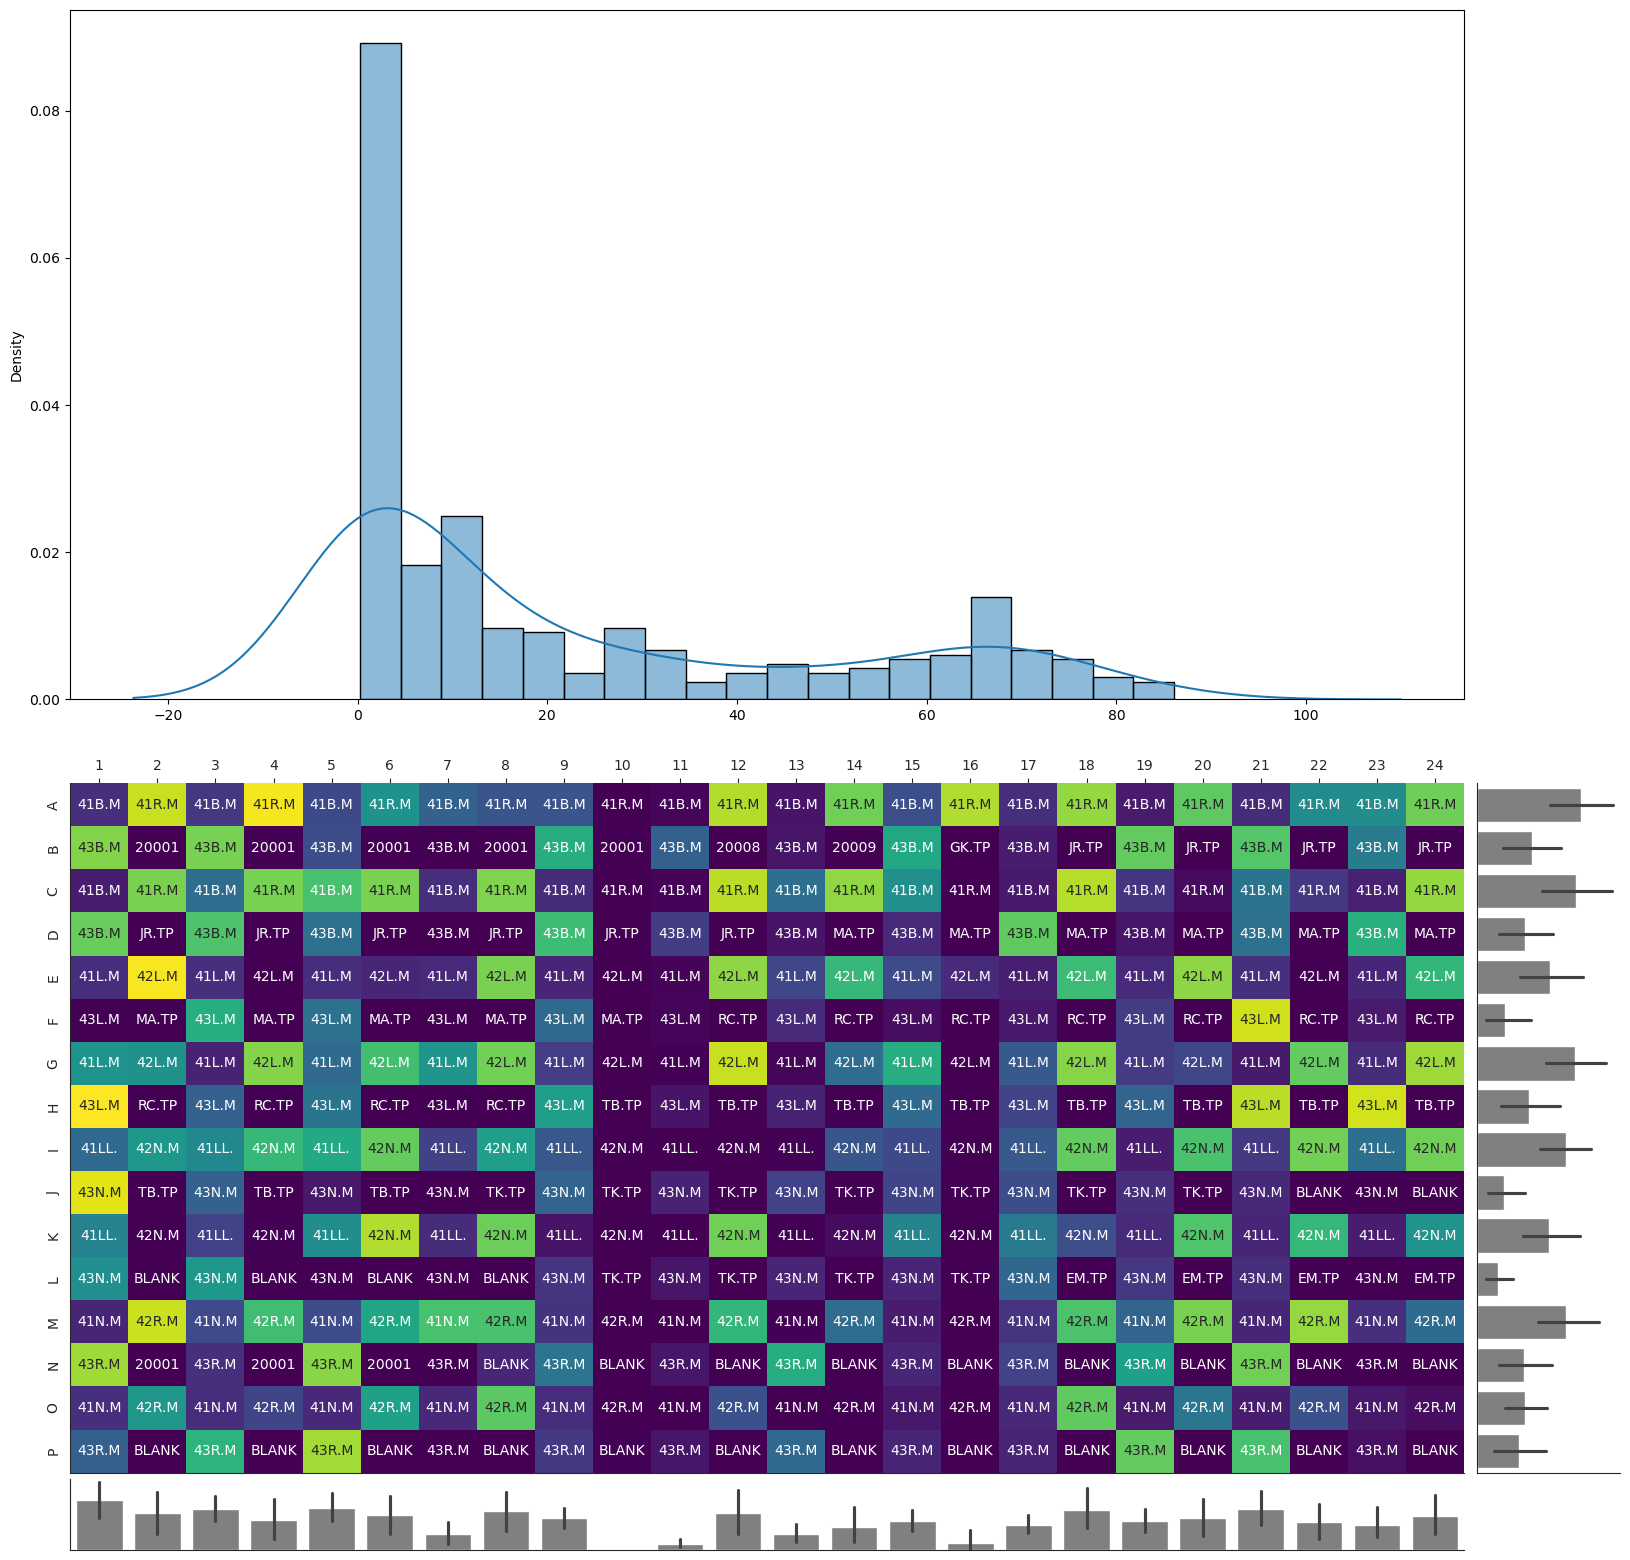

In [29]:
# get DNA concentration information
undiluted_dna_concs = make_2D_array(plate_df, data_col=UNDILUTED_CONC_KEY, 
                          well_col=WELL_COL).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=WELL_COL)

plot_plate_vals(undiluted_dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')

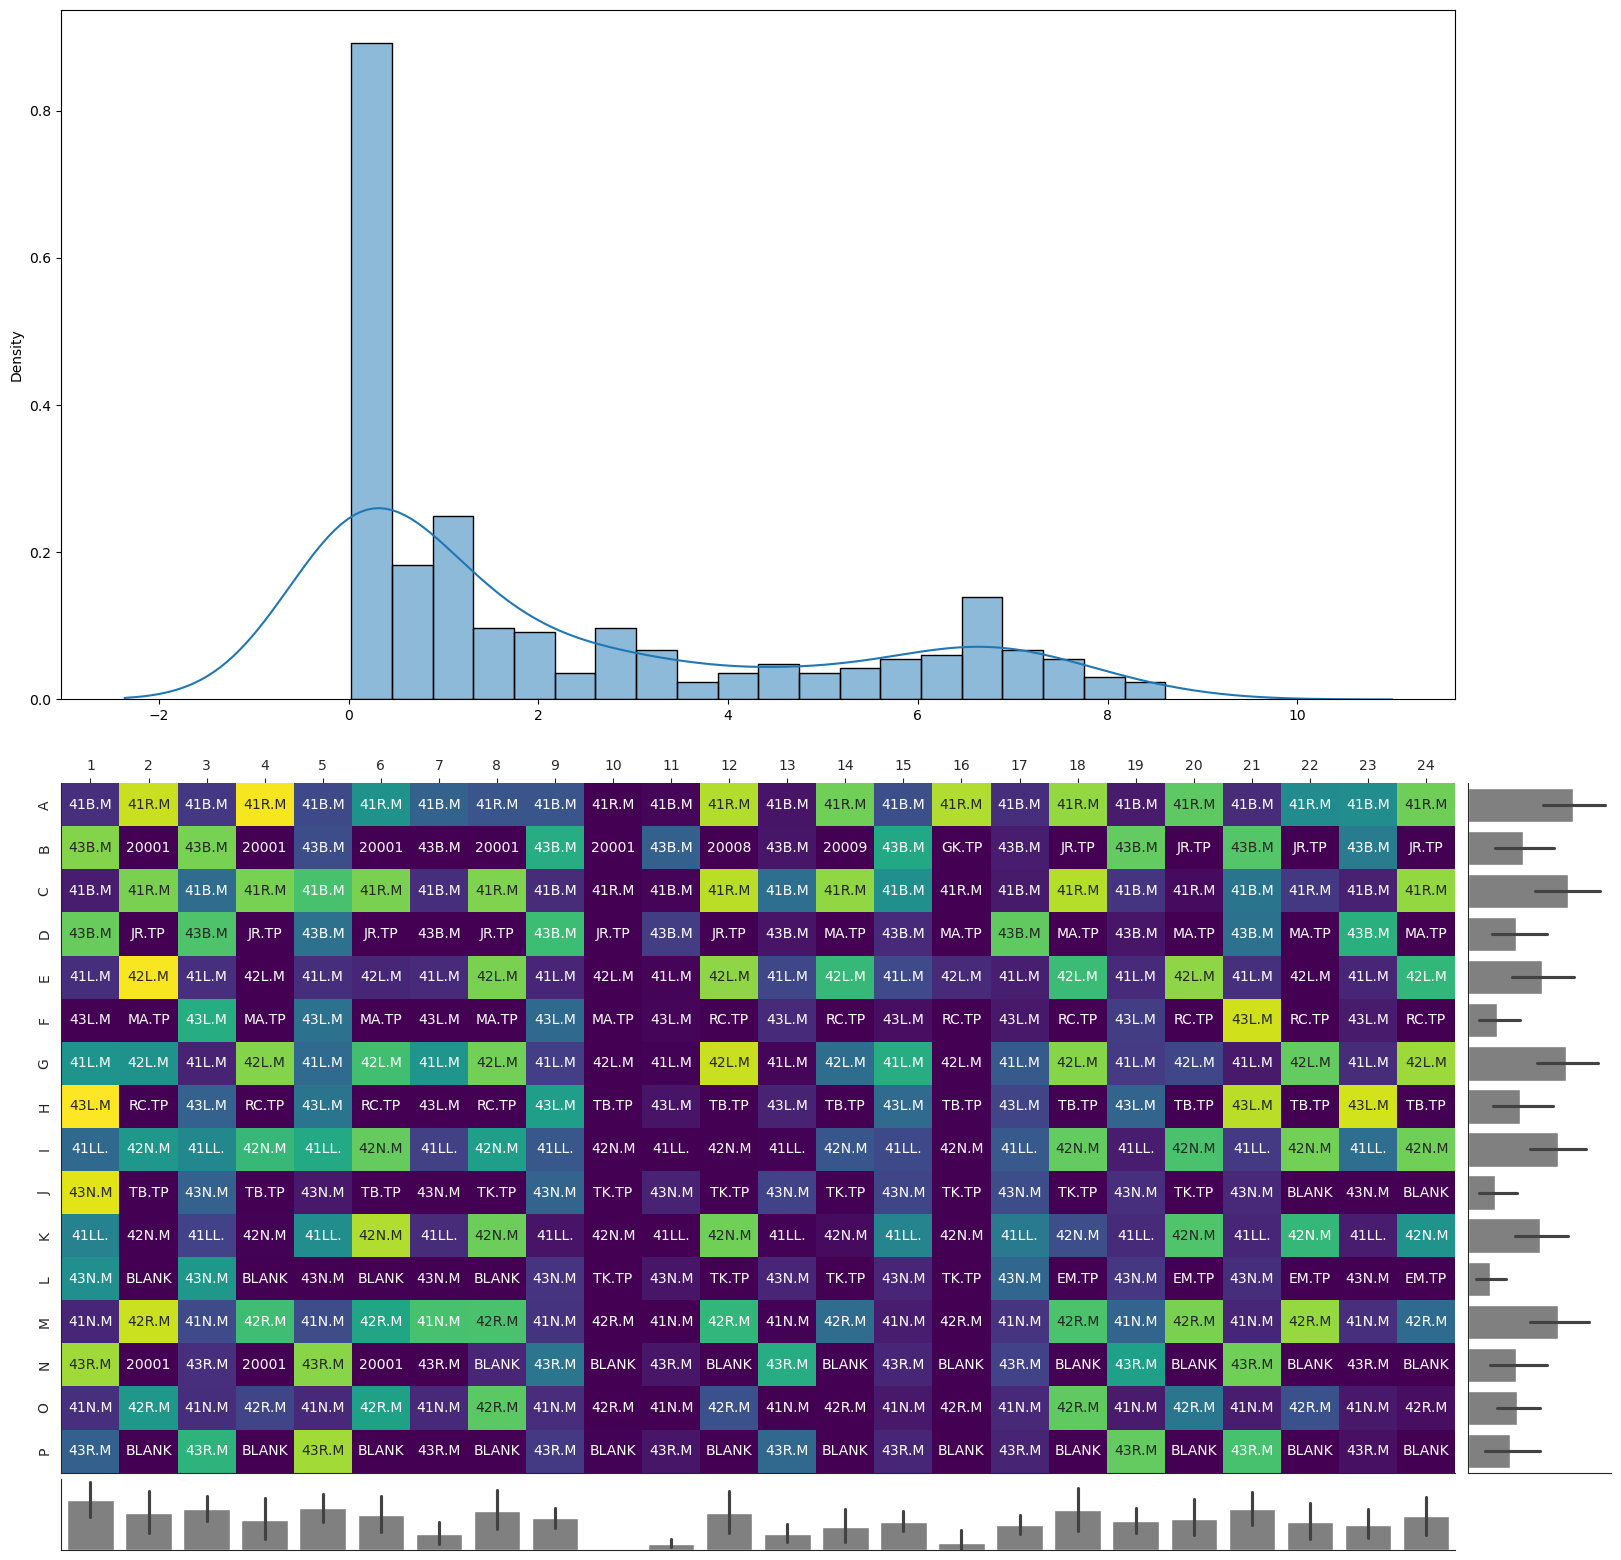

In [30]:
# get DNA concentration information
diluted_dna_concs = make_2D_array(plate_df, data_col=DILUTED_CONC_KEY, 
                                  well_col=WELL_COL).astype(float)

# get information for annotation
diluted_names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=WELL_COL)

plot_plate_vals(diluted_dna_concs,
                annot_str=diluted_names,
                color_map='viridis',
                annot_fmt='.5s')

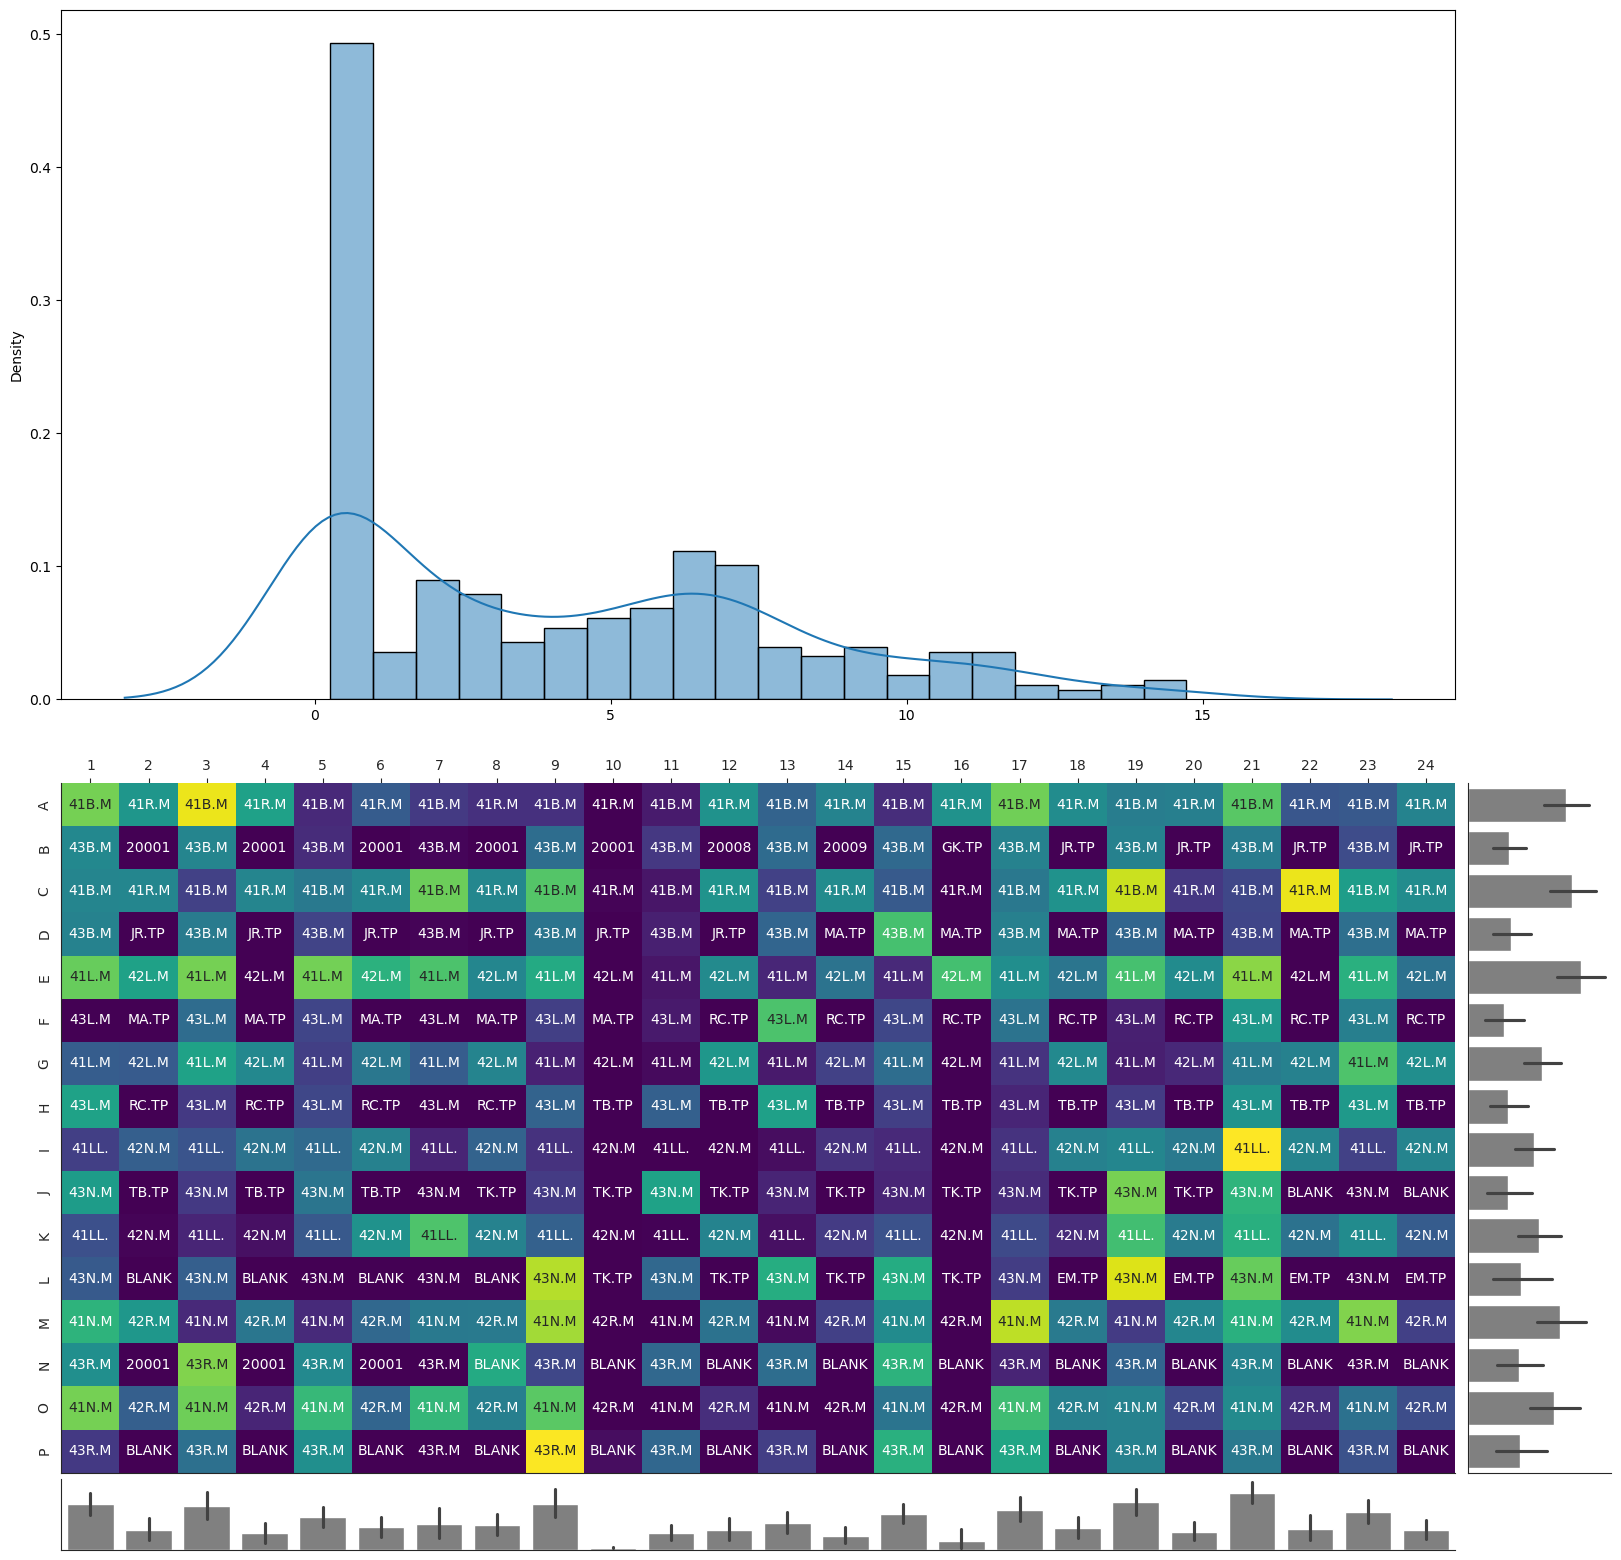

In [31]:
# get DNA concentration information
dna_concs = make_2D_array(plate_df, data_col=SAMPLE_DNA_CONC_KEY, 
                          well_col=WELL_COL).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=WELL_COL)

plot_plate_vals(dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')

#### Make sample replicates

Set replicate dictionary, if needed.

In [32]:
# Replicate formats:
# replicate_dict = {source1_quadrant:destination1_quadrant}
# replicate_dict = {source1_quadrant:[destination1_quadrants,destination1_quadrants]}
# Replicate example: 
# replicate_dict = {1:[2,3]}
# for no replicates, use:
replicate_dict = None

# 'Well' differs from 'Library Well' because the former specifies the 
# gDNA source well while the latter specifies the well (destination well) that 
# will contain the sequencing library for the sample. These contain the same
# info when replicates are not used, but differ when replicates ARE used,
# so it is safer to use 'Library Well' in both cases.
# (Careful!  well_col is a global variable used throughout rest of notebook)
well_col = LIB_WELL_COL

In [33]:
# initialize new PlateReplication object to manage metadata, conversions, etc.
# initialize w/preferred well_col.
pr = PlateReplication(well_col)

# set overwrite=False to detect any overwriting of source or destination quads 
# and raise an Error.
plate_df = pr.make_replicates(
    plate_df, replicates=replicate_dict, overwrite=True)

# replicates overlapping sample_wells for other samples should raise warning,
# but will be allowed
if 'True' in plate_df['contains_replicates'].unique():
    raise NotImplementedError("This notebook does not yet support replicates.")
    
    # plate_df['contains_replicates'] = True
    # # get DNA concentration information
    # dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', 
    #                           well_col=well_col).astype(float)
    # 
    # # get information for annotation
    # names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=well_col)
    # 
    # plot_plate_vals(dna_concs,
    #             annot_str=names,
    #             color_map='viridis',
    #             annot_fmt='.6s')
else:
    plate_df['contains_replicates'] = False
    
# show whether this plate contains replicates or not
f"Contains replicates: {plate_df['contains_replicates'].unique()}"

'Contains replicates: [False]'

#### gDNA concentration heatmap, Plate 1

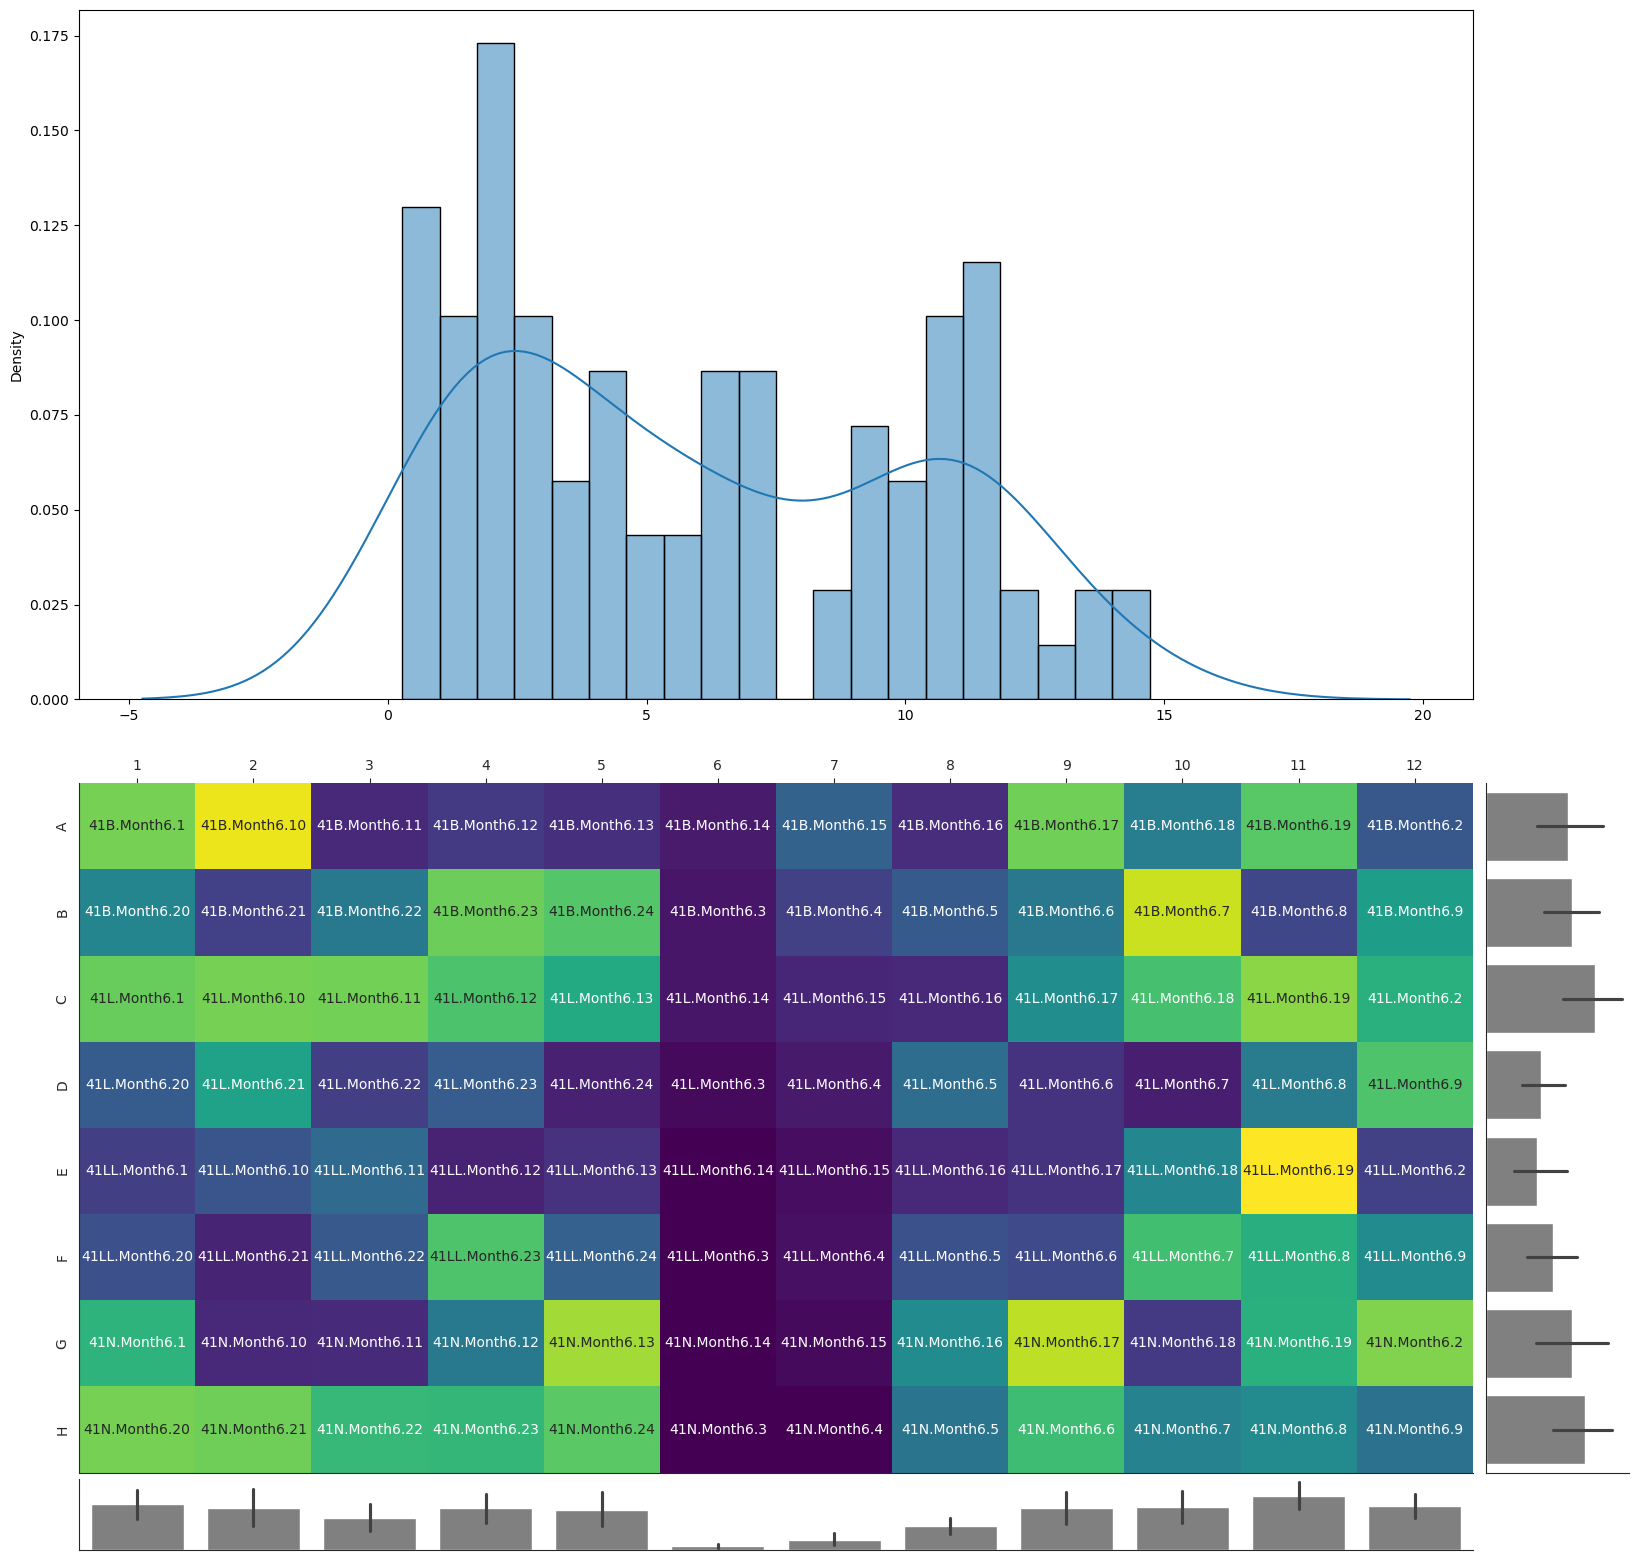

In [34]:
plot_plate_vals(dna_concs[np.ix_(EVEN_ROWS,EVEN_COLS)],
                annot_str= names[np.ix_(EVEN_ROWS,EVEN_COLS)],
                color_map='viridis',
                annot_fmt='')

#### gDNA concentration heatmap, Plate 2

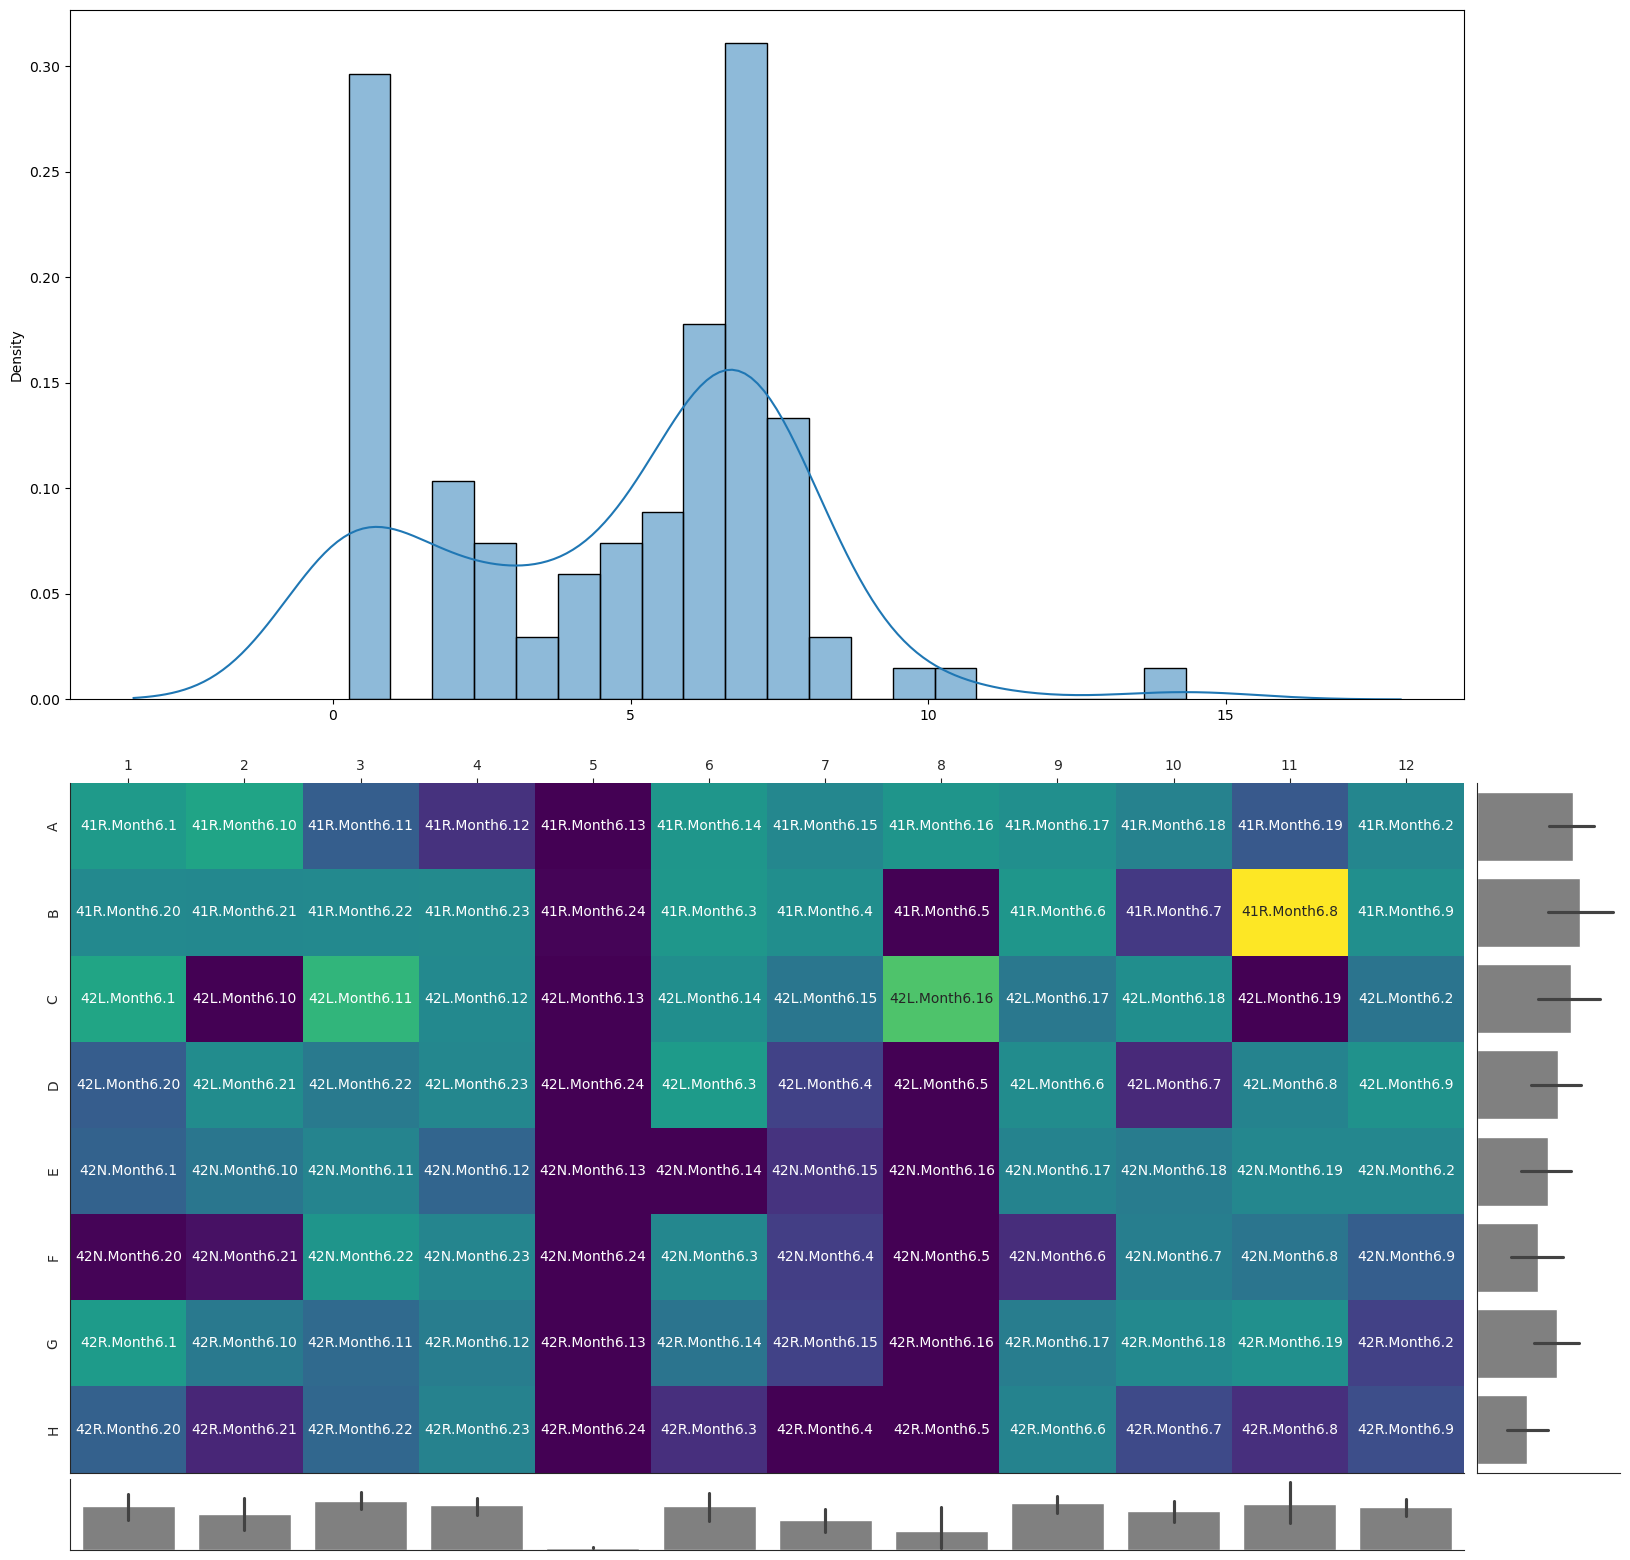

In [35]:
plot_plate_vals(dna_concs[np.ix_(EVEN_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(EVEN_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

#### gDNA concentration heatmap, Plate 3

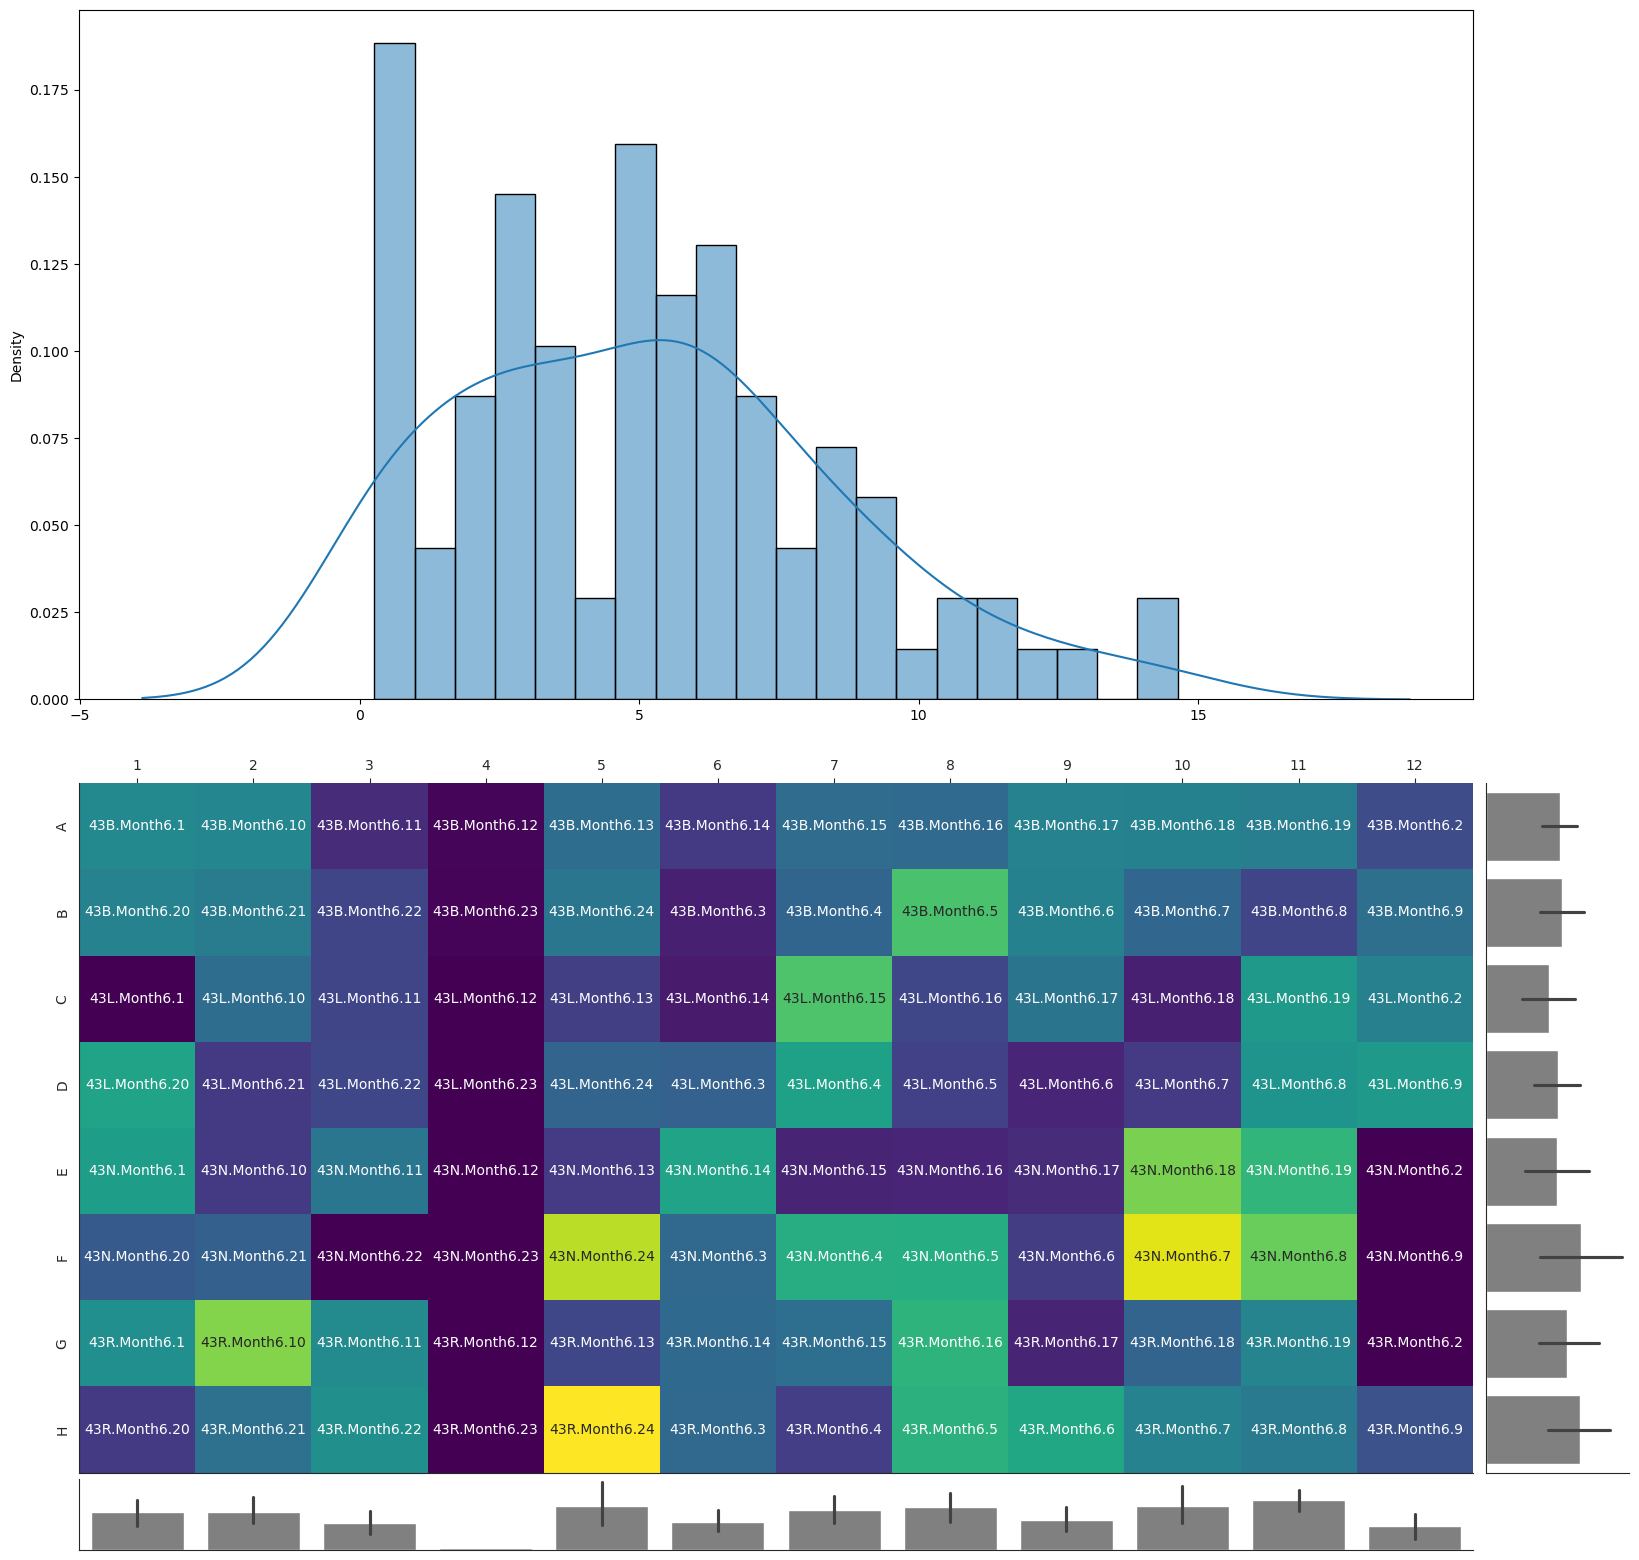

In [36]:
plot_plate_vals(dna_concs[np.ix_(ODD_ROWS,EVEN_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,EVEN_COLS)],
                    color_map='viridis',
                    annot_fmt='')


#### gDNA concentration heatmap, Plate 4

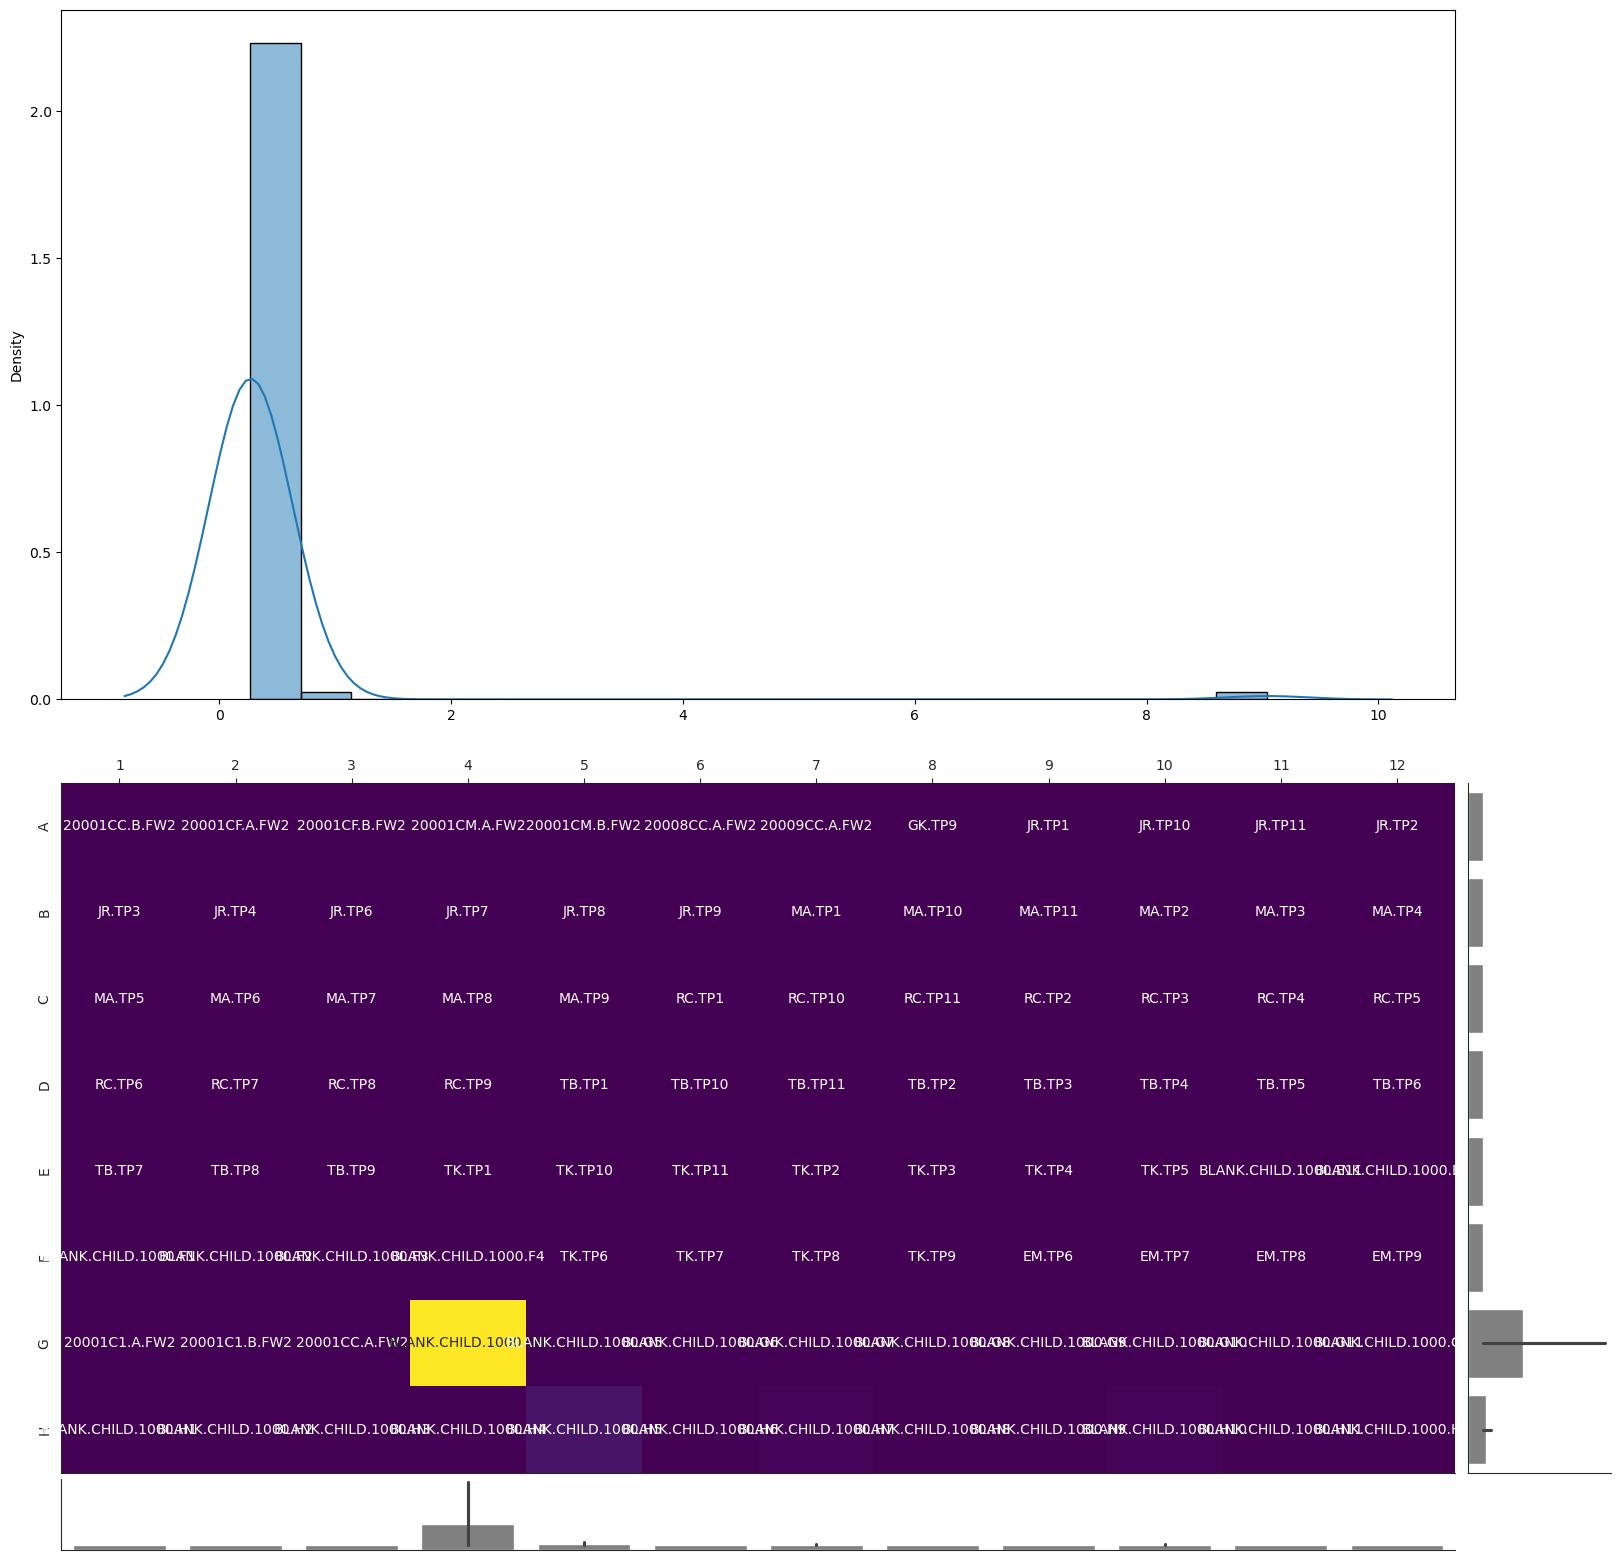

In [37]:
plot_plate_vals(dna_concs[np.ix_(ODD_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

### Part 1 of 4, Step 6 of 8: calculate normalization volumes and add to plate map

This step will calculate volumes for the DNA normalization pick list.

Check the desired values for:
 - **`ng`**: the desired quantity of DNA in normed plate, in ng
 - **`total_vol`**: the total volume of normalized DNA, in nL
 - **`min_vol`**: the minimum quantity of sample to add, in nL
 - **`resolution`**: the resolution of the Echo, in nL (usually 2.5)

In [38]:
ng = 7.5
total_vol = 5000
min_vol = 25
resolution = 2.5

NORMALIZED_WATER_VOL_KEY = 'Normalized water volume'

dna_vols = calculate_norm_vol(
    plate_df[SAMPLE_DNA_CONC_KEY], ng=ng, min_vol=min_vol, 
    max_vol=total_vol, resolution=resolution)
water_vols = total_vol - dna_vols

plate_df[NORMALIZED_DNA_VOL_KEY] = dna_vols
plate_df[NORMALIZED_WATER_VOL_KEY] = water_vols
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,Blank,Sample DNA Concentration_undiluted,Sample DNA Concentration_diluted,Sample DNA Concentration,extracted_gdna_concentration_ng_ul,Diluted,Library Well,contains_replicates,Normalized DNA volume,Normalized water volume
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,False,11.712,1.1712,11.7120,11.712,NaN,A1,False,640.0,4360.0
1,41B.Month6.10,2,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,False,14.294,1.4294,14.2940,14.294,NaN,A3,False,525.0,4475.0
2,41B.Month6.11,3,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16_diluted,plate_1,A,...,False,19.047,1.9047,1.9047,19.047,True,A5,False,3937.5,1062.5
3,41B.Month6.12,4,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16_diluted,plate_1,A,...,False,27.218,2.7218,2.7218,27.218,True,A7,False,2755.0,2245.0
4,41B.Month6.13,5,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16_diluted,plate_1,A,...,False,22.552,2.2552,2.2552,22.552,True,A9,False,3325.0,1675.0


In [39]:
# NORMALIZED_DNA_VOL_KEY = 'Normalized DNA volume'
# NORMALIZED_WATER_VOL_KEY = 'Normalized water volume'
# NORM_SOURCE_PLATE_KEY = "Normalization Source Plate"
# 
# def calc_agnostic_norm_vols(
#         plate_df, conc_col_name, dna_col_name, water_col_name, 
#         ng, total_vol, min_vol, resolution):
#     dna_vols = calculate_norm_vol(
#         plate_df[conc_col_name], ng=ng, min_vol=min_vol, 
#         max_vol=total_vol, resolution=resolution)
#     water_vols = total_vol - dna_vols
#     
#     for curr_col_name in [dna_col_name, water_col_name]:
#         if curr_col_name in plate_df.columns:
#             warnings.warn(f"Overwriting {curr_col_name} column in plate_df.")
#     
#     plate_df[dna_col_name] = dna_vols
#     plate_df[water_col_name] = water_vols
#     return plate_df
# 
# 
# def _nan_out_low_concs(plate_df, conc_col_name, min_conc):
#     low_concs = plate_df[conc_col_name] < min_conc
#     if low_concs.any():
#         plate_df.loc[low_concs, conc_col_name] = np.nan
#     return plate_df
# 
# 
# def calc_tellseq_norm_vols(
#         plate_df, min_conc, ng, total_vol, min_vol, resolution):
#     
#     # calculate the norm vols for the dilution plate
#     diluted_dna_vol_name = f"{NORMALIZED_DNA_VOL_KEY}{DILUTION_SUFFIX}"
#     diluted_water_vol_name = f"{NORMALIZED_WATER_VOL_KEY}{DILUTION_SUFFIX}"
#     plate_df = calc_agnostic_norm_vols(
#         plate_df, DILUTED_CONC_NAME, 
#         diluted_dna_vol_name, diluted_water_vol_name,
#         ng, total_vol, min_vol, resolution)
# 
#     # NaN out any with a concentration less than min
#     plate_df = _nan_out_low_concs(
#         plate_df, DILUTED_CONC_NAME, min_conc)
#     
#     # calculate the norm vols for the original plate
#     orig_dna_vol_name = f"{NORMALIZED_DNA_VOL_KEY}{ORIG_SUFFIX}"
#     orig_water_vol_name = f"{NORMALIZED_WATER_VOL_KEY}{ORIG_SUFFIX}"
#     plate_df = calc_agnostic_norm_vols(
#         plate_df, ORIG_CONC_NAME, 
#         orig_dna_vol_name, orig_water_vol_name,
#         ng, total_vol, min_vol, resolution)
#     
#     # NaN out any with a concentration less than min
#     plate_df = _nan_out_low_concs(plate_df, ORIG_CONC_NAME, min_conc)
#     
#     # identify any samples where both normalized vols are NaN and 
#     # warn the user if any found
#     nan_orig_mask = plate_df[orig_dna_vol_name].isna()
#     nan_diluted_mask = plate_df[diluted_dna_vol_name].isna()
#     both_nan = plate_df[nan_orig_mask & nan_diluted_mask]
# 
#     if len(both_nan) > 0:
#         warnings.warn(
#             f"The following samples do not have a concentration above "
#             f"{min_conc} in either the original or diluted plate: "
#             f"{plate_df.loc[both_nan, PM_SAMPLE_KEY]}")
#         
#     # first set Sample Concentration column to be the undiluted concentration
#     # for any sample that has more than the minimum concentration--but then 
#     # overwrite with the diluted concentration for any sample that has a
#     # *diluted* concentration above the minimum, since we want to prefer those
#     # values
#     std_norm_cols = \
#         [SAMPLE_DNA_CONC_KEY, NORMALIZED_DNA_VOL_KEY, NORMALIZED_WATER_VOL_KEY]
#     plate_df.loc[~nan_orig_mask, std_norm_cols] = \
#         plate_df[[ORIG_CONC_NAME, orig_dna_vol_name, orig_water_vol_name]]
#     plate_df.loc[~nan_diluted_mask, NORM_SOURCE_PLATE_KEY] = \
#         plate_df[PM_COMPRESSED_PLATE_NAME_KEY] + DILUTION_SUFFIX
#     
#     plate_df.loc[~nan_diluted_mask, std_norm_cols] = \
#         plate_df[[DILUTED_CONC_NAME, diluted_dna_vol_name, diluted_water_vol_name]]
#     plate_df.loc[~nan_diluted_mask, NORM_SOURCE_PLATE_KEY] = \
#         plate_df[PM_COMPRESSED_PLATE_NAME_KEY]  # No suffix
#     
#     return plate_df

In [40]:
# plate_df = calc_tellseq_norm_vols(
#     plate_df, min_conc, ng, total_vol, min_vol, resolution)
# plate_df.head()

### Part 1 of 4, Step 7 of 8 (optional): Add synDNA spike-in

In [41]:
# Set syndna_pool_number to 1 if syndna is being used; otherwise, leave as None
syndna_pool_number = None
plate_df = add_syndna(plate_df, 
                      syndna_pool_number=syndna_pool_number,
                      syndna_concentration=2.22)

/Users/abirmingham/Work/Repositories/fork_metagenomics_pooling_notebook/metapool/metapool.py:1606: UserWarning: Returning input plate dataframe;no synDNA will be added to this prep
  warnings.warn("Returning input plate dataframe;"


In [42]:
def is_absquant(a_plate_df):
    return bool(np.any(a_plate_df[SYNDNA_POOL_NUM_KEY].unique()))

In [43]:
f'For this plate, is_absquant = {is_absquant(plate_df)}'


'For this plate, is_absquant = False'

In [44]:
if is_absquant(plate_df):
    syndna_well='A1'
    syndna_plate = 'synDNA plate'
    syndna_picklist = \
        format_dna_norm_picklist(
            np.array(plate_df['synDNA volume']),
            np.zeros(plate_df.shape[0]),
            np.repeat(syndna_well,plate_df.shape[0]),
            dest_wells = np.array(plate_df[well_col]),
            sample_names = np.array(plate_df[PM_SAMPLE_KEY]),
            sample_plates = np.repeat(syndna_plate,plate_df.shape[0]))

In [45]:
if is_absquant(plate_df):
    # Write the picklist as .txt
    syndna_picklist_fp = './test_output/Input_Norm/YYYY_MM_DD_Celeste_Adaptation_16-21_matrix_syndna_absquant.txt'

    if os.path.isfile(syndna_picklist_fp):
        print("Warning! This file exists already.")

In [46]:
if is_absquant(plate_df):
    with open(syndna_picklist_fp, 'w') as f:
        f.write(syndna_picklist)

    !head {syndna_picklist_fp}

### Part 1 of 4, Step 8 of 8: Make pick list and write to file

Format the Echo-compatible pick list.

In [47]:
norm_picklist = format_dna_norm_picklist(
    np.array(plate_df[NORMALIZED_DNA_VOL_KEY]),
    np.array(plate_df[NORMALIZED_WATER_VOL_KEY]),
    np.array(plate_df['Well']),
    dest_wells = np.array(plate_df[well_col]),
    sample_names = np.array(plate_df[PM_SAMPLE_KEY]),
    sample_plates = np.array(plate_df['Compressed Plate Name']),
    dna_concs = np.array(plate_df[SAMPLE_DNA_CONC_KEY]))

In [48]:
# Write the picklist as .txt
norm_picklist_fp = './test_output/Input_Norm/YYYY_MM_DD_Celeste_Adaptation_16-21_inputnorm.txt'

if os.path.isfile(norm_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [49]:
with open(norm_picklist_fp, 'w') as f:
    f.write(norm_picklist)
    
!head {norm_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Concentration	Transfer Volume	Destination Plate Name	Destination Well
41B.Month6.1	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A1	11.712	640.0	NormalizedDNA	A1
41B.Month6.10	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A3	14.294	525.0	NormalizedDNA	A3
41B.Month6.11	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000_dilution	384PP_AQ_BP2	A5	1.9047	3937.5	NormalizedDNA	A5
41B.Month6.12	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000_dilution	384PP_AQ_BP2	A7	2.7218	2755.0	NormalizedDNA	A7
41B.Month6.13	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000_dilution	384PP_AQ_BP2	A9	2.2552	3325.0	NormalizedDNA	A9
41B.Month6.14	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A11	1.315	5000.0	NormalizedDNA	A11
41B.Month6.15	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000	384PP_AQ_BP2	A13	4.808	1560.0	NormalizedDNA	A13
41B.Month6.16	Celeste_Adaptation_12986_16_17_18_CHILD_15510_1000_

## Part 2 (of 4): Workflow for assigning barcodes

This portion of the notebook will assign index values and construct an Echo picklist file for adding barcodes. 

As inputs, it requires:
1. A plate_df dataframe (from previous step)
2. A tab-delimited tellseq barcode file, containing Well and Barcode_ID columns
3. The name of the tellseq barcode source plate

The workflow then:
1. reads in the tellseq barcode list
2. assigns indices per sample
3. produces an Echo-formatted pick list file

### Part 2 of 4, Step 1 of 3: Read in tellseq barcode list

This is a file that contains each unique tellseq barcode on a separate line,
along with plate and well location information. It should look something like this:

```
Well,Barcode_96_Well_Position,Barcode_ID
A1,A1,C501
B1,A2,C509
C1,B1,C502
D1,B2,C510
E1,C1,C503
F1,C2,C511
G1,D1,C504
H1,D2,C512
I1,E1,C505
J1,E2,C513
K1,F1,C506
```

In [50]:
barcodes_plate_name = 'TellSeq_Barcode_Plate_1'
#barcodes_fp = './test_output/iTru/TELL-Seq_Barcodes_PP_Primer_Plate - PP_Primer_Position.csv'
barcodes_fp = '/Users/abirmingham/Downloads/TELL-Seq_Barcodes_PP_Primer_Plate - PP_Primer_Position.csv'

if not os.path.isfile(barcodes_fp):
    print("Problem! %s is not a path to a valid file" % barcodes_fp)

In [51]:
barcodes = pd.read_csv(barcodes_fp, dtype=str)
# rename the columns to match what `format_index_picklist` expects
# and add the plate information
barcodes.rename(columns={'Well': 'i5 well', 'Barcode_ID': 'i5 name'}, inplace=True)
barcodes['i5 plate'] = barcodes_plate_name
barcodes.head()

,i5 well,Barcode_96_Well_Position,i5 name,i5 plate
0,A1,A1,C501,TellSeq_Barcode_Plate_1
1,B1,A2,C509,TellSeq_Barcode_Plate_1
2,C1,B1,C502,TellSeq_Barcode_Plate_1
3,D1,B2,C510,TellSeq_Barcode_Plate_1
4,E1,C1,C503,TellSeq_Barcode_Plate_1


### Part 2 of 4, Step 2 of 3: Assign tellseq barcodes

In [52]:
def sort_by_col_then_row(a_df, well_key='Well'):
    # remove the first character from the contents of a_df[well_key] and 
    # store it in its own column named f"{well_key}_row"
    a_df[f"{well_key}_row"] = a_df[well_key].str[:1]
    
    # take everything BUT the first character in the contents of a_df[well_key]
    # and convert it to an integer and store it in its own column named
    # f"{well_key}_col"
    a_df[f"{well_key}_col"] = a_df[well_key].str[1:].astype(int)
    
    # sort the dataframe first by the column and then by the row
    a_df.sort_values(by=[f"{well_key}_col", f"{well_key}_row"], inplace=True)
    return a_df

def get_num_barcode_sets_needed(plate_df, barcodes_df):
    # if num_barcode_sets_needed is not an integer, throw an error
    num_barcode_sets_needed = plate_df.shape[0]/ barcodes_df.shape[0]
    if num_barcode_sets_needed % 1 != 0:
        raise ValueError(
            f"Number of barcodes ({barcodes_df.shape[0]}) "
            f"does not divide evenly into number of samples "
            f"]({plate_df.shape[0]})")
    return int(num_barcode_sets_needed)


def assign_barcodes(plate_df, barcodes_df):
    # get the plate_df sorted by col then row
    plate_df = sort_by_col_then_row(plate_df, well_key=LIB_WELL_COL)
    # get the barcodes sorted by col then row
    barcodes = sort_by_col_then_row(barcodes_df, well_key='i5 well')
    
    # make a new barcodes_sets_df that duplicates the barcodes dataframe
    # num_barcode_sets_needed times
    concat_dfs = []
    num_barcode_sets = get_num_barcode_sets_needed(plate_df, barcodes)
    for i in range(num_barcode_sets):
        curr_set = barcodes.copy()
        curr_set['barcode_set'] = i + 1  #1-based, assuming non-tech users
        concat_dfs.append(curr_set)
    barcode_sets_df = pd.concat(concat_dfs, ignore_index=True)
    
    # merge the (sorted) plate_df and barcode_sets_df
    plate_df = pd.merge(plate_df, barcode_sets_df, 
                        left_index=True, right_index=True)
    return plate_df, barcode_sets_df

In [53]:
plate_df, barcode_sets_df = assign_barcodes(plate_df, barcodes)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,syndna_pool_number,Library Well_row,Library Well_col,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,None,A,1,A1,A1,C501,TellSeq_Barcode_Plate_1,A,1,1
192,43B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,3,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_18_diluted,plate_3,A,...,None,B,1,A1,A1,C501,TellSeq_Barcode_Plate_1,A,1,3
12,41B.Month6.20,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,B,...,None,C,1,M1,G1,C507,TellSeq_Barcode_Plate_1,M,1,1
204,43B.Month6.20,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,3,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_18_diluted,plate_3,B,...,None,D,1,M1,G1,C507,TellSeq_Barcode_Plate_1,M,1,3
24,41L.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,C,...,None,E,1,I2,E3,C521,TellSeq_Barcode_Plate_1,I,2,1


In [54]:
barcode_sets_df.head()

,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set
0,A1,A1,C501,TellSeq_Barcode_Plate_1,A,1,1
1,B1,A2,C509,TellSeq_Barcode_Plate_1,B,1,1
2,C1,B1,C502,TellSeq_Barcode_Plate_1,C,1,1
3,D1,B2,C510,TellSeq_Barcode_Plate_1,D,1,1
4,E1,C1,C503,TellSeq_Barcode_Plate_1,E,1,1


### Part 2 of 4, Step 3 of 3: Make index pick list and write to file

Format the Echo-compatible pick list.

In [55]:
index_picklist = format_index_picklist(
    plate_df[PM_SAMPLE_KEY], plate_df[well_col], barcode_sets_df)

In [56]:
# Write the picklist as .txt
index_picklist_fp = './test_output/Indices/YYYY_MM_DD_Celeste_Adaptation_16-21_indices_matrix.txt'

if os.path.isfile(index_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [57]:
with open(index_picklist_fp, 'w') as f:
    f.write(index_picklist)

!head {index_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Transfer Volume	Index Name	Destination Plate Name	Destination Well
41B.Month6.1	TellSeq_Barcode_Plate_1	384LDV_AQ_B2	A1	250	C501	IndexPCRPlate	A1
43B.Month6.1	TellSeq_Barcode_Plate_1	384LDV_AQ_B2	B1	250	C509	IndexPCRPlate	B1
41B.Month6.20	TellSeq_Barcode_Plate_1	384LDV_AQ_B2	C1	250	C502	IndexPCRPlate	C1
43B.Month6.20	TellSeq_Barcode_Plate_1	384LDV_AQ_B2	D1	250	C510	IndexPCRPlate	D1
41L.Month6.1	TellSeq_Barcode_Plate_1	384LDV_AQ_B2	E1	250	C503	IndexPCRPlate	E1
43L.Month6.1	TellSeq_Barcode_Plate_1	384LDV_AQ_B2	F1	250	C511	IndexPCRPlate	F1
41L.Month6.20	TellSeq_Barcode_Plate_1	384LDV_AQ_B2	G1	250	C504	IndexPCRPlate	G1
43L.Month6.20	TellSeq_Barcode_Plate_1	384LDV_AQ_B2	H1	250	C512	IndexPCRPlate	H1
41LL.Month6.1	TellSeq_Barcode_Plate_1	384LDV_AQ_B2	I1	250	C505	IndexPCRPlate	I1


## Part 3 (of 4): Workflow for calculating pooling

This portion of the notebook calculates pooling based on fluorescent
 quantification values and produces visual outputs to interpret and check 
 values. 

As inputs, this workflow requires:
1. A plate map DataFrame (from previous step)
2. MiniPico output (tab-delimited text format with columns 'Concentration' and 'Well')

The workflow:
1. reads in MiniPico output and calculates estimated library concentration
2. calculates pooling values and generates an Echo pick list

### Part 3 of 4, Step 1 of 7: read in MiniPico library concentration
Enter correct path to MiniPico file:

In [58]:
lib_concs_fp = './test_data/Quant/MiniPico/2022_07_Celeste_Adaptation_16_17_18_21_CleanLib_quant.txt'

In [59]:
lib_concs = read_pico_csv(lib_concs_fp, plate_reader='SpectraMax_i3x',
                          conc_col_name='MiniPico Library DNA Concentration')
lib_concs.rename(columns={'Well':well_col},inplace=True)
plate_df = pd.merge(plate_df, lib_concs, on=well_col)

plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,Library Well_row,Library Well_col,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set,MiniPico Library DNA Concentration
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,A,1,A1,A1,C501,TellSeq_Barcode_Plate_1,A,1,1,0.566
1,43B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,3,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_18_diluted,plate_3,A,...,B,1,A1,A1,C501,TellSeq_Barcode_Plate_1,A,1,3,0.513
2,41B.Month6.20,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,B,...,C,1,M1,G1,C507,TellSeq_Barcode_Plate_1,M,1,1,0.831
3,43B.Month6.20,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,3,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_18_diluted,plate_3,B,...,D,1,M1,G1,C507,TellSeq_Barcode_Plate_1,M,1,3,0.777
4,41L.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,C,...,E,1,I2,E3,C521,TellSeq_Barcode_Plate_1,I,2,1,1.078


### Part 3 of 4, Step 2 of 7: calculate sample concentration from MiniPico

You will want to make sure that 'size' is correct for your average library size.

In [60]:
plate_df['MiniPico Library Concentration'] = \
    compute_pico_concentration(
        plate_df['MiniPico Library DNA Concentration'], size=500)
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,Library Well_col,i5 well,Barcode_96_Well_Position,i5 name,i5 plate,i5 well_row,i5 well_col,barcode_set,MiniPico Library DNA Concentration,MiniPico Library Concentration
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,1,A1,A1,C501,TellSeq_Barcode_Plate_1,A,1,1,0.566,1.715152
1,43B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,3,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_18_diluted,plate_3,A,...,1,A1,A1,C501,TellSeq_Barcode_Plate_1,A,1,3,0.513,1.554545
2,41B.Month6.20,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,B,...,1,M1,G1,C507,TellSeq_Barcode_Plate_1,M,1,1,0.831,2.518182
3,43B.Month6.20,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,3,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_18_diluted,plate_3,B,...,1,M1,G1,C507,TellSeq_Barcode_Plate_1,M,1,3,0.777,2.354545
4,41L.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,C,...,1,I2,E3,C521,TellSeq_Barcode_Plate_1,I,2,1,1.078,3.266667


### Part 3 of 4, Step 3 of 7: visualize MiniPico values

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

#### Library concentration by sample DNA concentration:

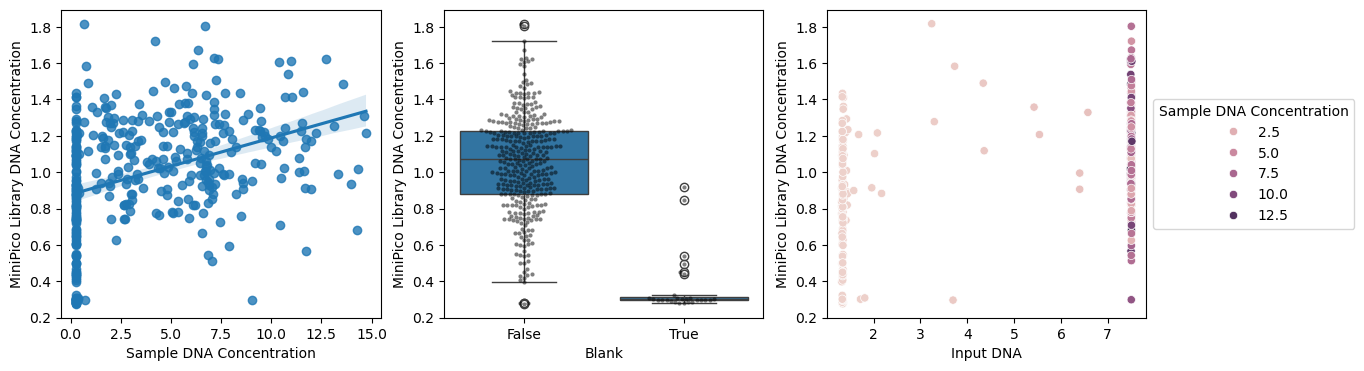

In [61]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
plate_df['Input DNA'] = plate_df['Sample DNA Concentration']*plate_df['Normalized DNA volume']/1000
sns.regplot(x="Sample DNA Concentration", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax1)
sns.boxplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2)
sns.swarmplot(x="Blank", y="MiniPico Library DNA Concentration", data=plate_df, ax = ax2,
              size=3,color='black',alpha=0.5)
sns.scatterplot( x="Input DNA",y="MiniPico Library DNA Concentration",hue='Sample DNA Concentration',data=plate_df ,ax = ax3)
ax3.legend(title='Sample DNA Concentration',loc='center left', bbox_to_anchor=(1, 0.5))

In [62]:
blanks_gdna_concs = plate_df.loc[plate_df['Blank']==True,'Sample DNA Concentration']
samples_gdna_concs = plate_df.loc[plate_df['Blank']==False,'Sample DNA Concentration']
mannwhitneyu(samples_gdna_concs, blanks_gdna_concs)

MannwhitneyuResult(statistic=np.float64(8117.0), pvalue=np.float64(2.992204728657328e-09))

In [63]:
blanks_lib_concs = plate_df.loc[plate_df['Blank']==True,'MiniPico Library Concentration']
samples_lib_concs = plate_df.loc[plate_df['Blank']==False,'MiniPico Library Concentration']
mannwhitneyu(samples_lib_concs, blanks_lib_concs)

MannwhitneyuResult(statistic=np.float64(9348.5), pvalue=np.float64(3.846256694931654e-16))

#### Library concentration heatmap, whole plate

In [64]:
# get concentration and pooling values for plotting
concs = make_2D_array(plate_df, data_col="MiniPico Library Concentration", well_col=well_col).astype(float)
dna = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col=well_col).astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col=PM_SAMPLE_KEY, well_col=well_col)

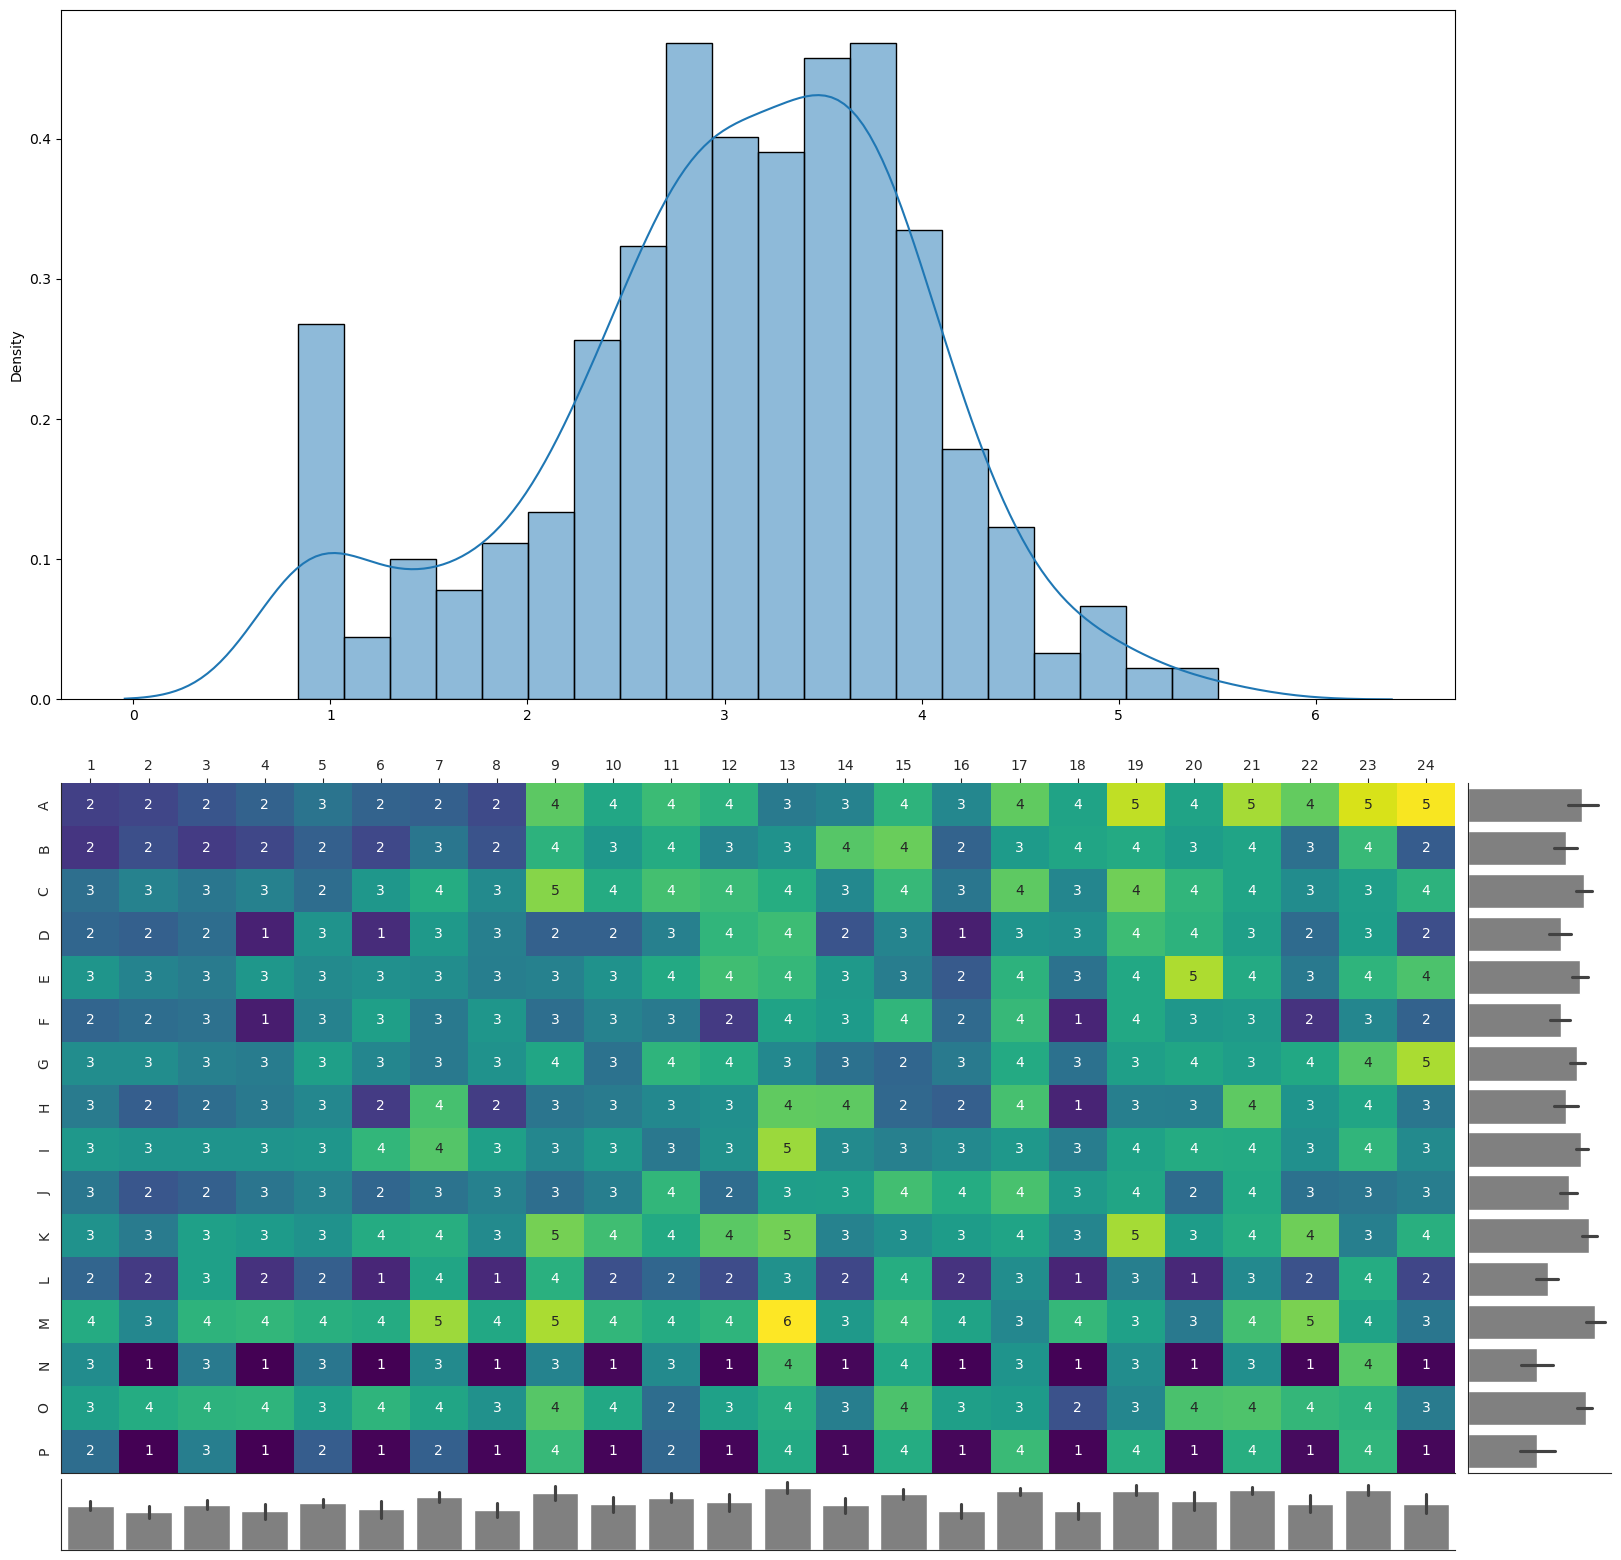

In [65]:
plot_plate_vals(concs, color_map='viridis')

#### Plate maps for individual constituent plates

##### Library concentration heatmap, Plate 1

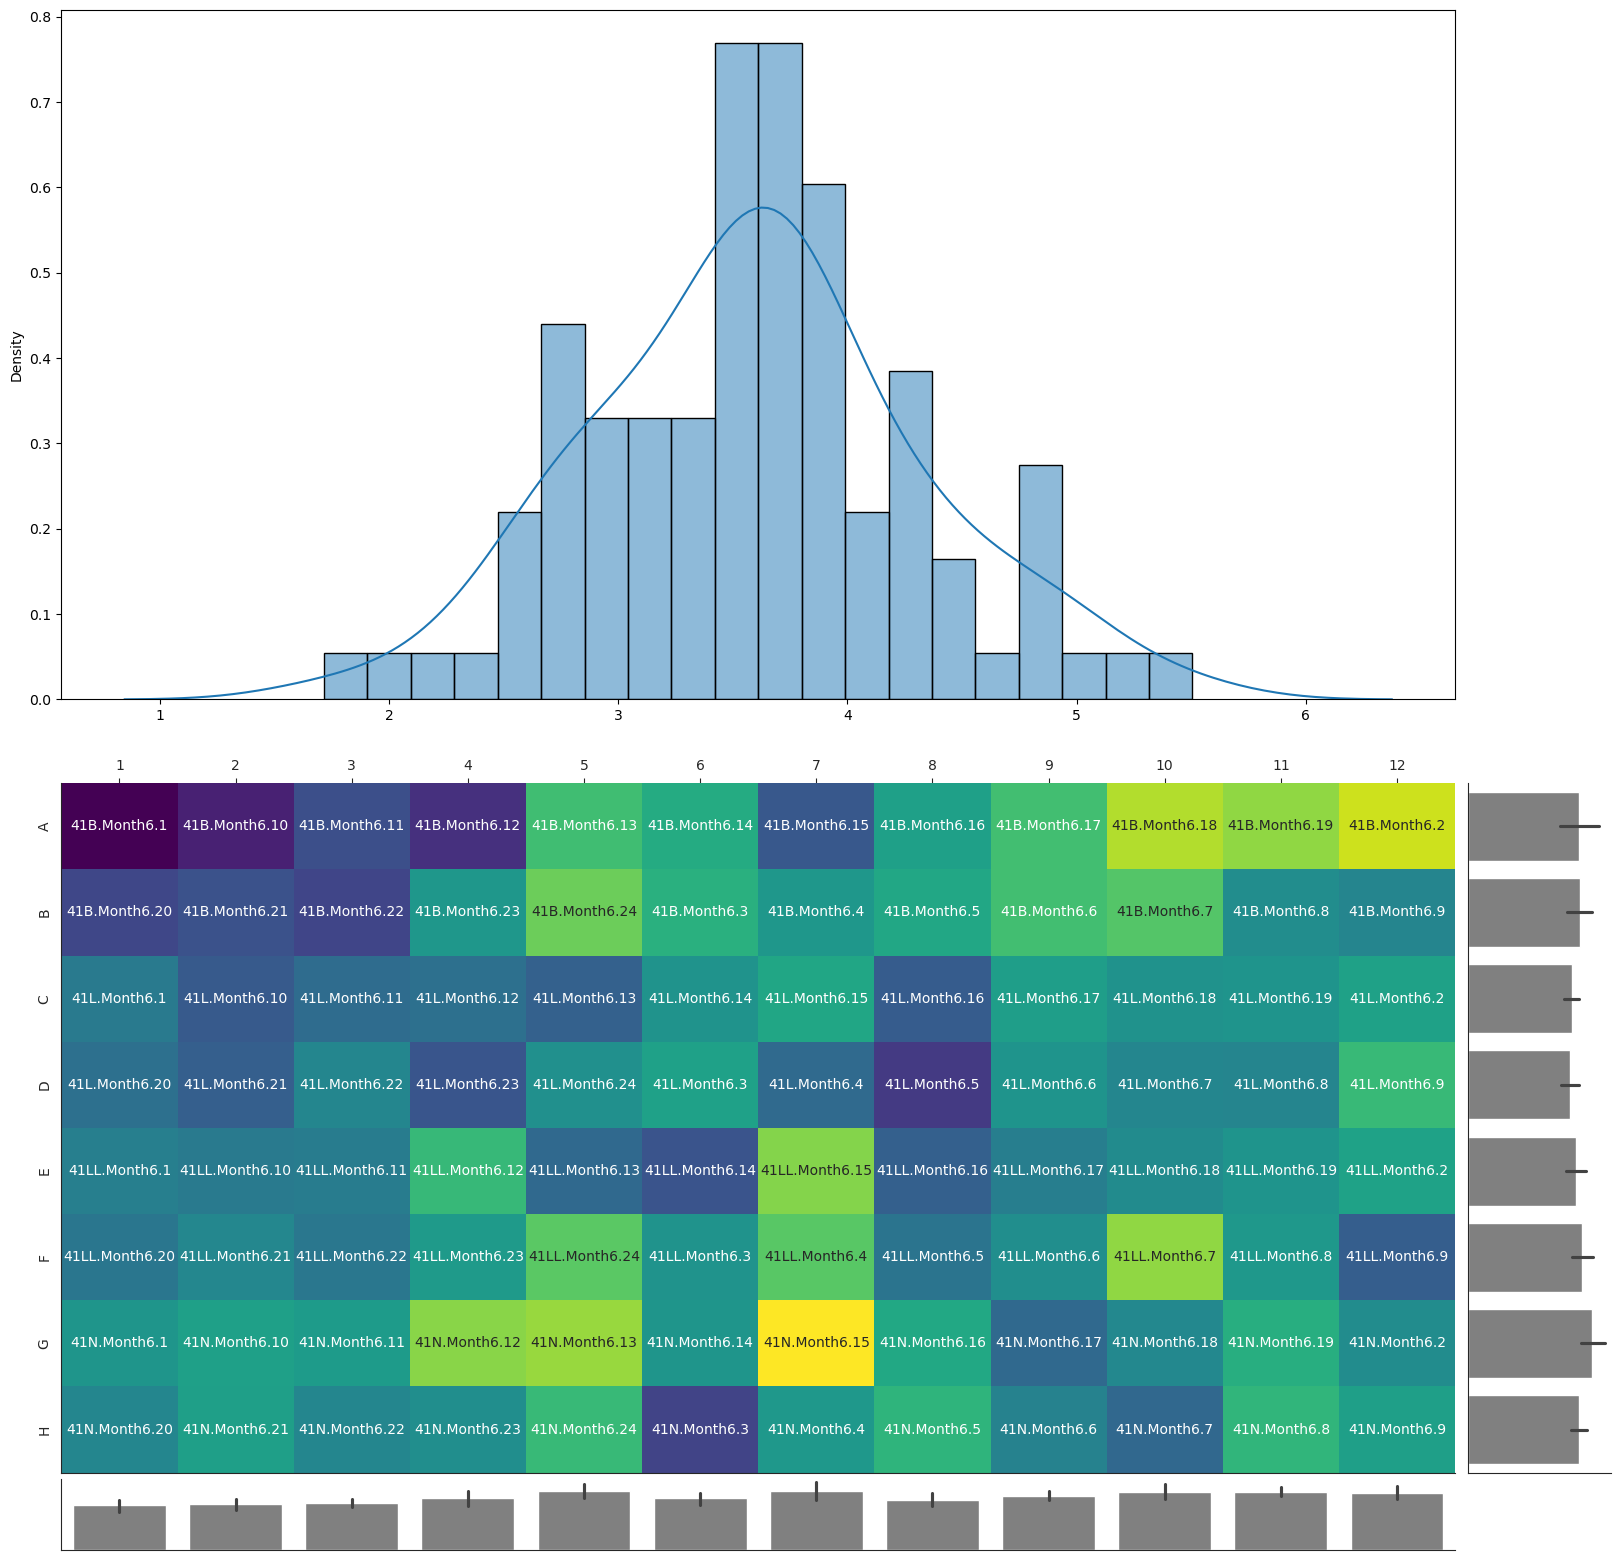

In [66]:
plot_plate_vals(concs[np.ix_(EVEN_ROWS,EVEN_COLS)],
                    annot_str= names[np.ix_(EVEN_ROWS,EVEN_COLS)],
                    color_map='viridis',
                    annot_fmt='')

##### Library concentration heatmap, Plate 2

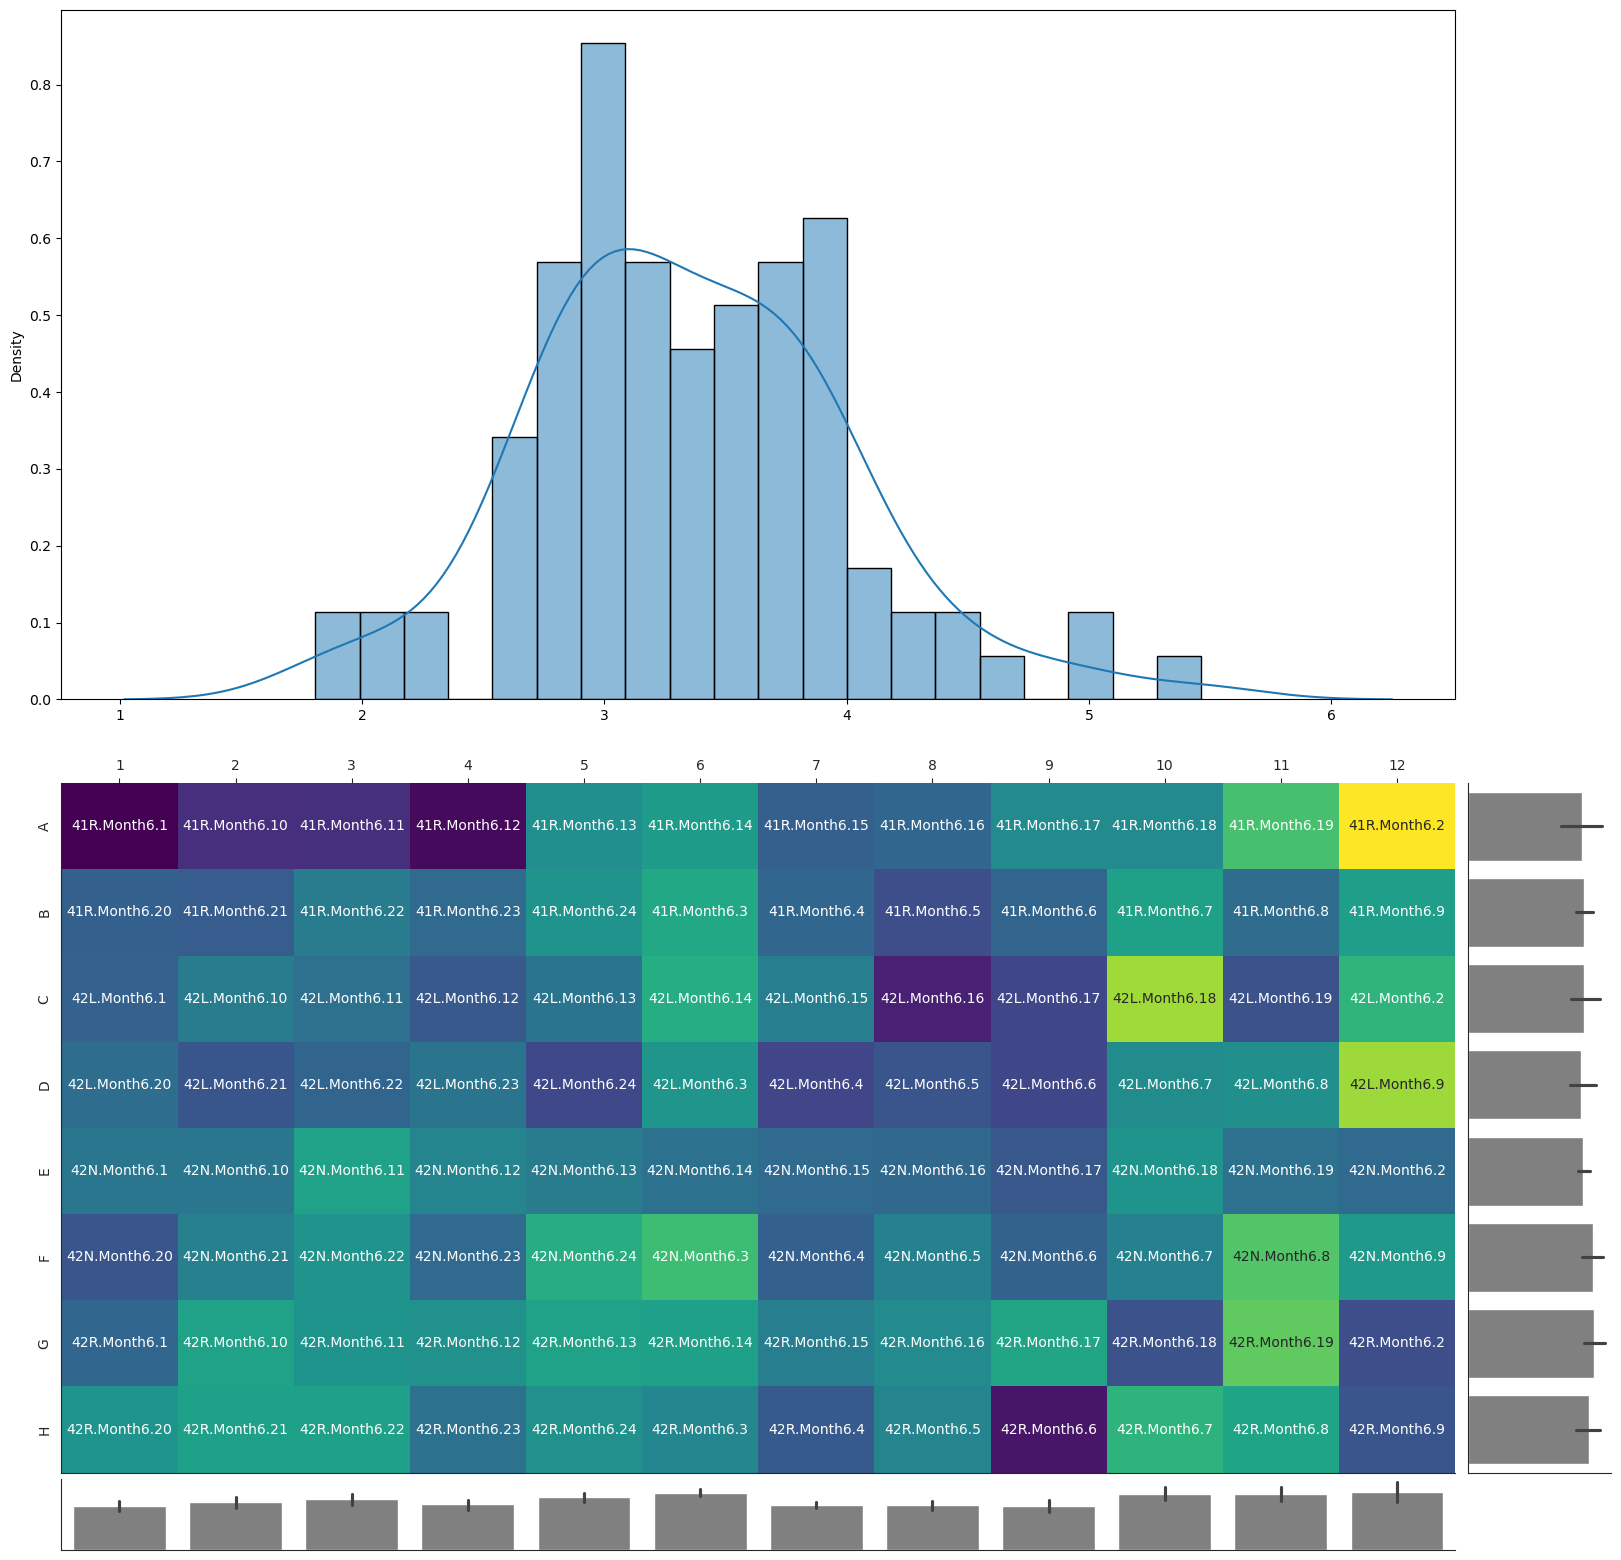

In [67]:
plot_plate_vals(concs[np.ix_(EVEN_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(EVEN_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

##### Library concentration heatmap, Plate 3

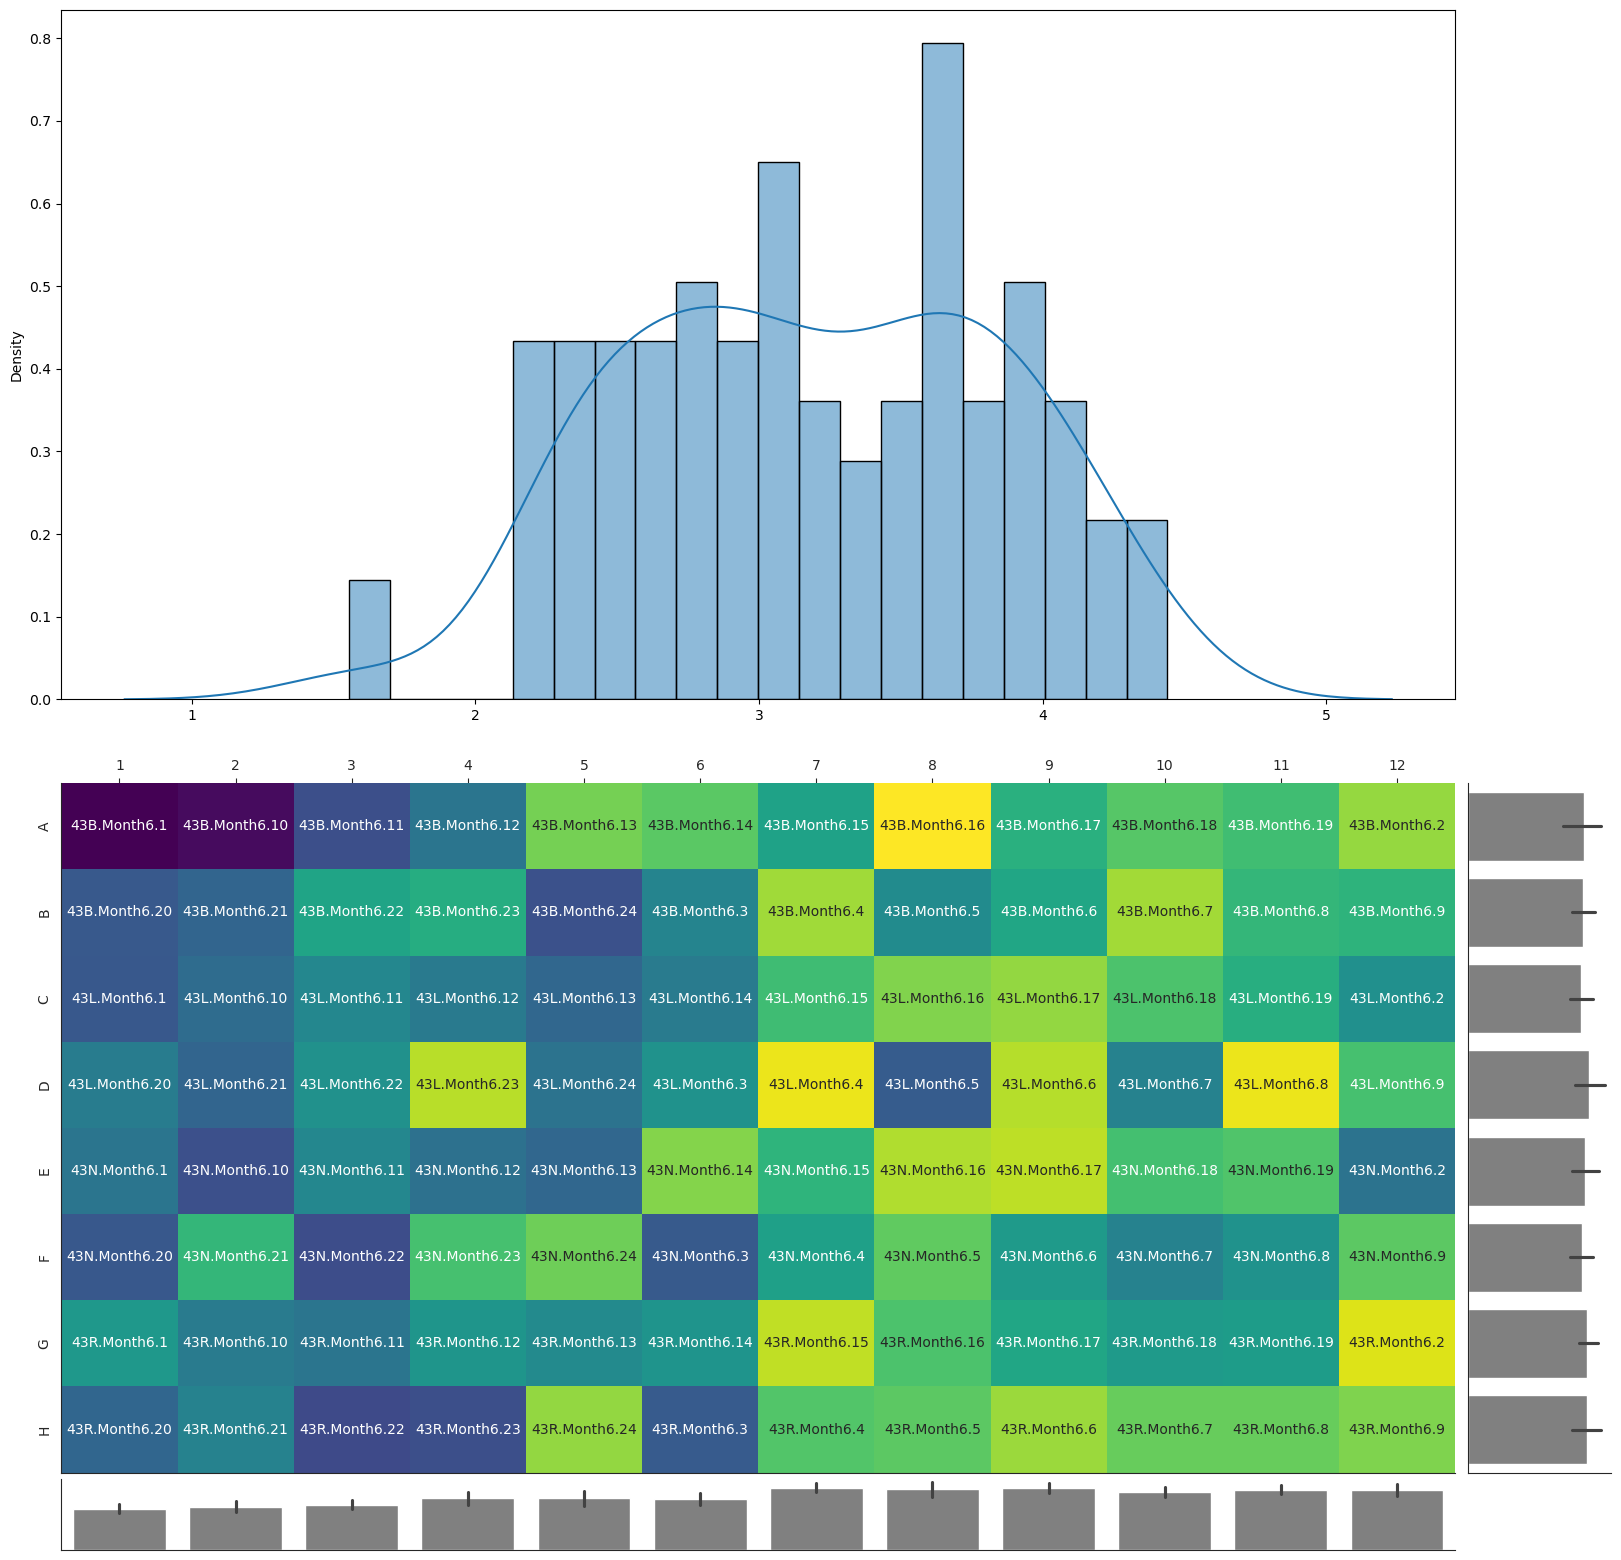

In [68]:
plot_plate_vals(concs[np.ix_(ODD_ROWS,EVEN_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,EVEN_COLS)],
                    color_map='viridis',
                    annot_fmt='')

##### Library concentration heatmap, Plate 4

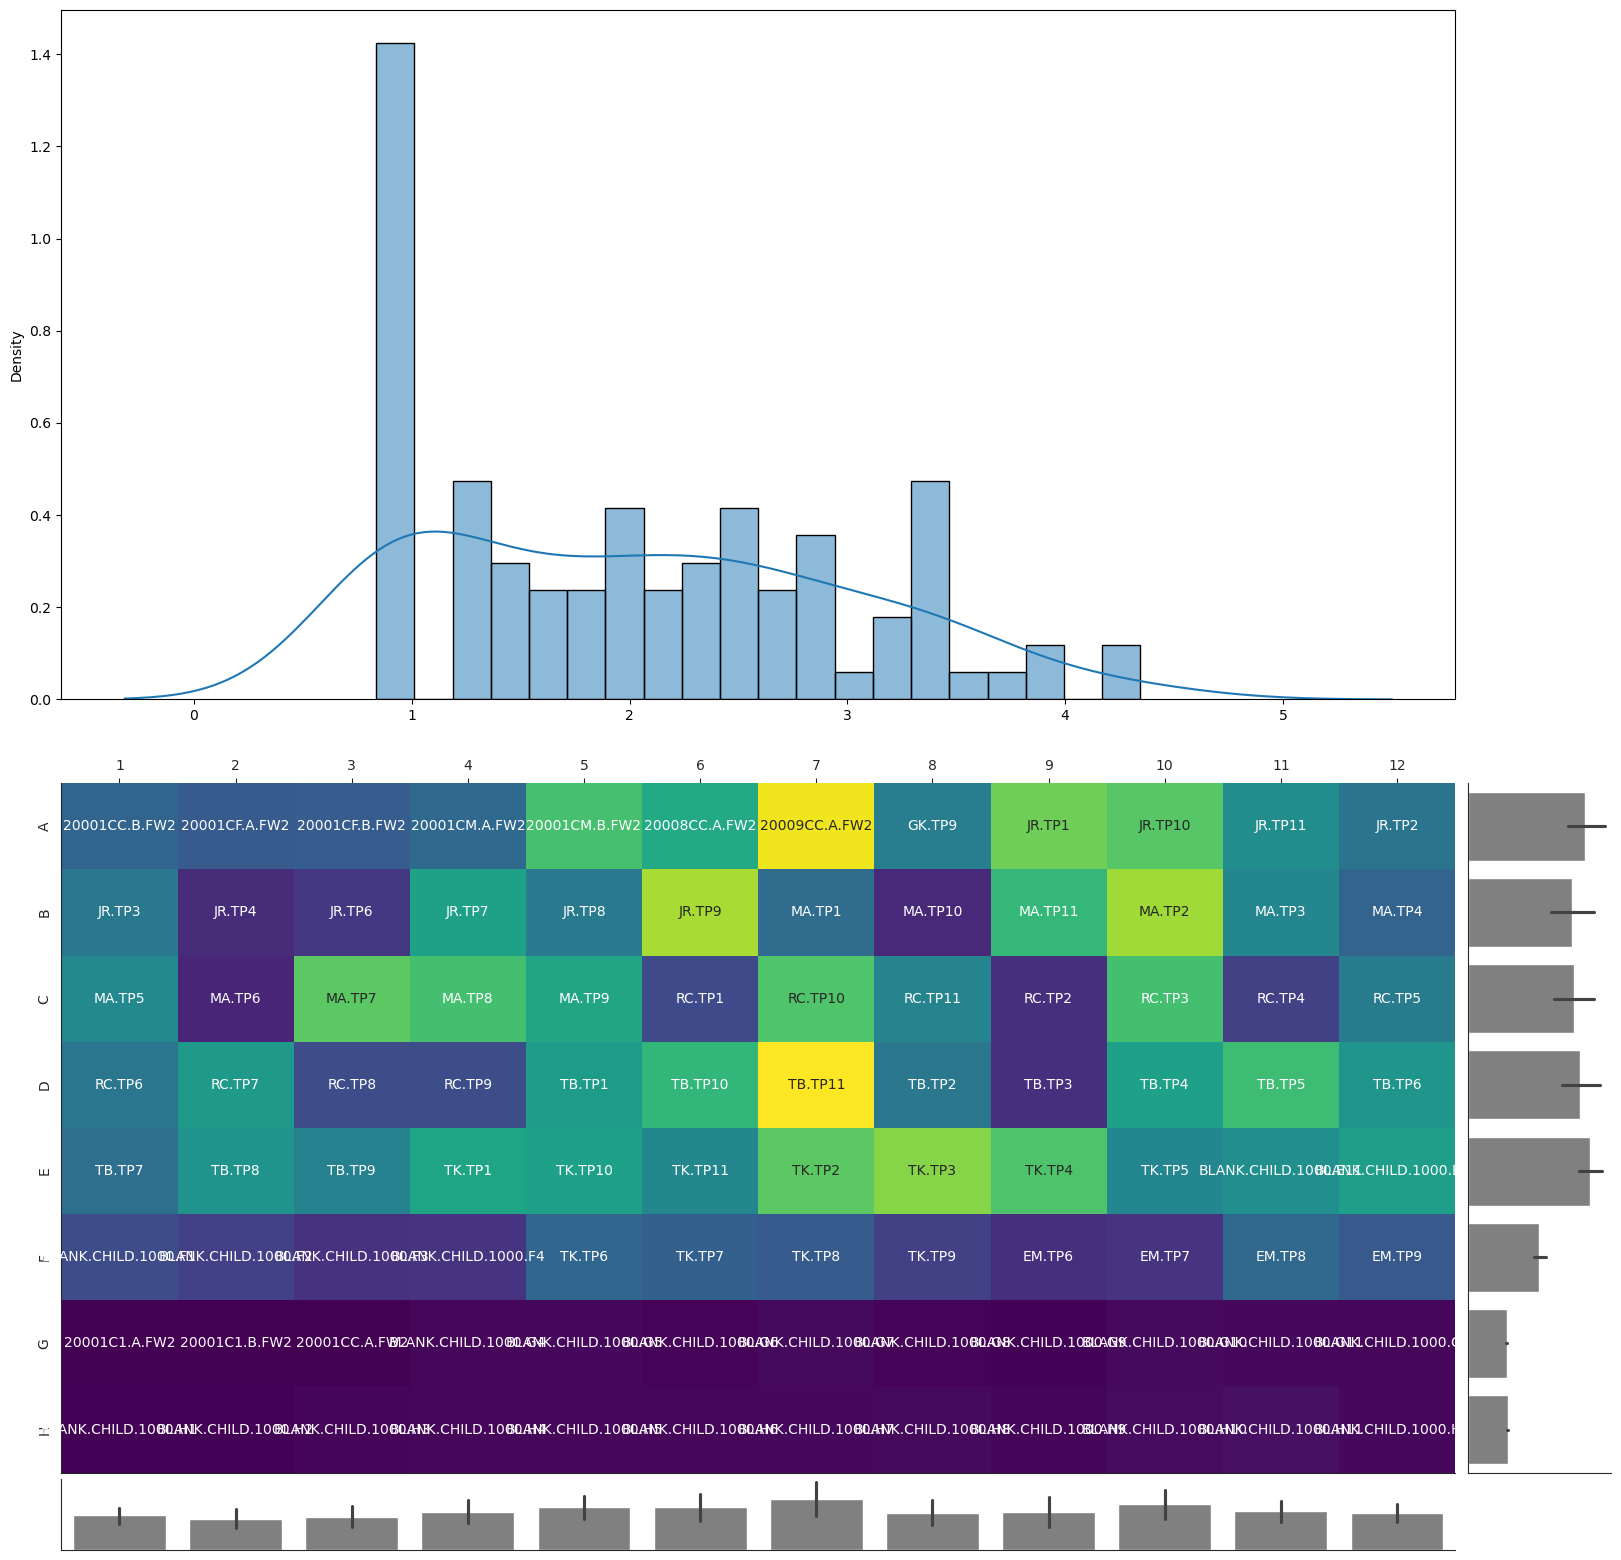

In [69]:
plot_plate_vals(concs[np.ix_(ODD_ROWS,ODD_COLS)],
                    annot_str= names[np.ix_(ODD_ROWS,ODD_COLS)],
                    color_map='viridis',
                    annot_fmt='')

### Part 3 of 4, Step 4 of 7: calculate pooling values for MiniPico with autopool

This step will calculate the sample pooling, and update the sample data frame with the pool info.
There are two automated methods to pool:
1. **norm**: This will attempt to generate a normalized pool, automatically inferring the best parameter for pooling.
    - ***pool_failures***:
        - _high_: will pool failures at the highest pooling volume from optimized pooling.
        - _low_: will pool failures at the lowest pooling volume from optimized pooling.

2. **evp**: This will pool an even volume per sample.
    - ***total_vol***: (Optional, Default: 100µL) The total volume to pool, in uL. Each sample will be pooled at 1/N of that volume, where N is total number of samples in the prep.

3. **automate**: (Optional, Default = True) When False, this argument will allow one input parameters for **Legacy** arguments. 

> **Legacy**
> There are legacy parameters to control pooling behaviors when autopool automation (automate=True) returns a poor result. To use these parameters, one must pass automate=False.

>   - **min_conc**: (default: 0) This is the minimum concentration for a sample to be considered for pooling.
    Set to 0 to pool all samples, regardless of concentration. Increasing this will have the 
    effect of increasing pool concentration, at the expense of samples dropping out. 
>   - **floor_conc**: This is the lowest concentration equivalent for which a sample will be 
    accurately pooled. Samples below this concentration will be pooled to the volume that they 
    would have been if they were actually that concentration. For example, if `floor_conc=20`, 
    and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 
    10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect 
    of increasing pool concentration, but decreasing read counts for low-concentration samples. 
>   - **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing
    this will increase the overall volume of the pool.


#### Calculate and plot pooling volumes

Floor concentration: 1.2030303030303031
Pool concentration: 3.04
Pool volume: 190000.00


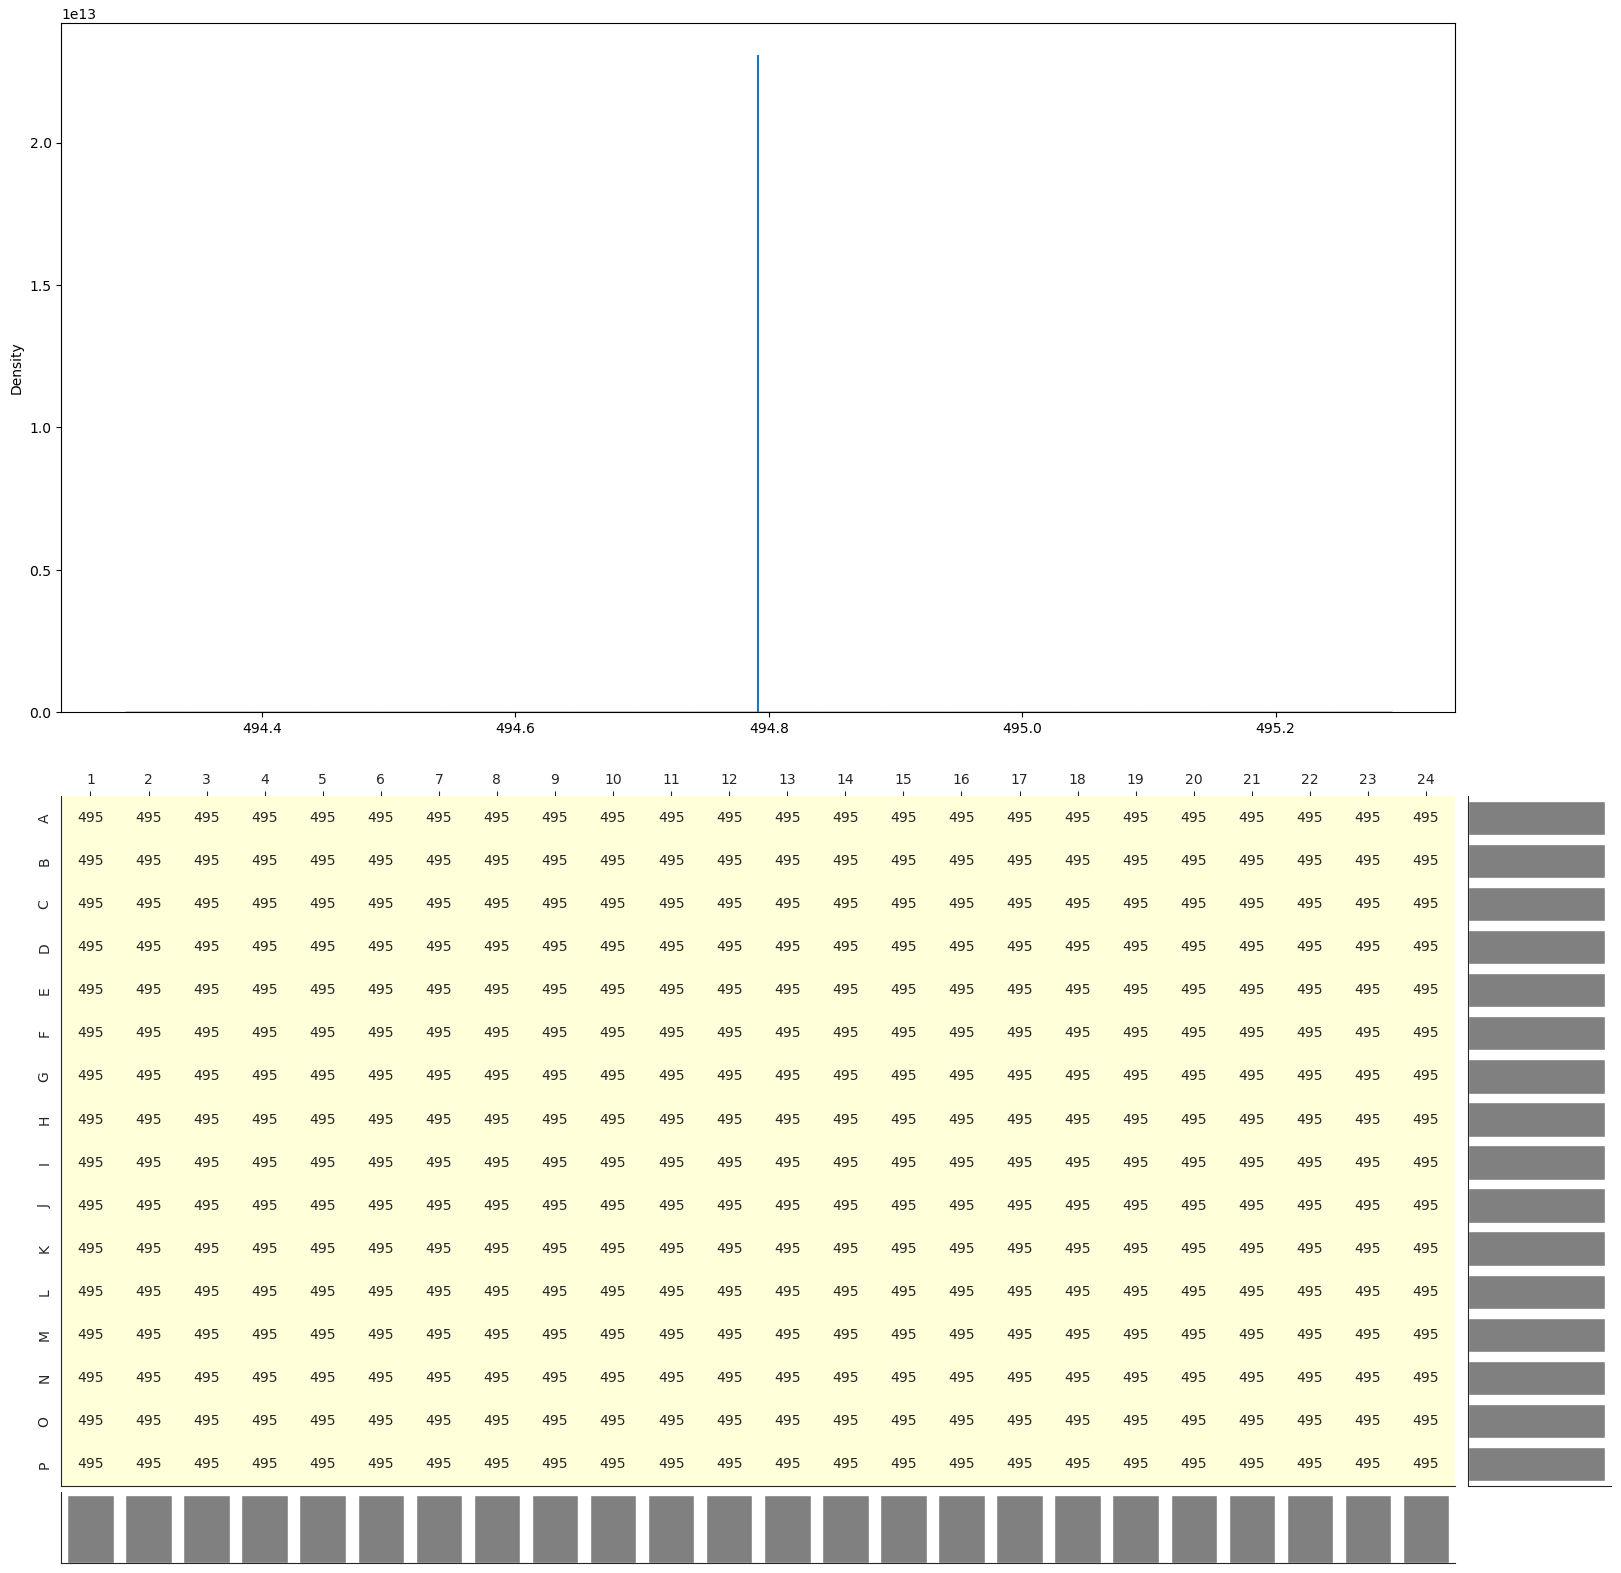

In [70]:
threshold = find_threshold(plate_df['MiniPico Library Concentration'], plate_df['Blank'])
plate_df = autopool(plate_df,method='evp',total_vol=190)

# visualize
print("Floor concentration: {}".format(threshold))
vols = make_2D_array(plate_df, data_col='MiniPico Pooled Volume', well_col=well_col).astype(float)
conc, vol = estimate_pool_conc_vol(plate_df['MiniPico Pooled Volume'], plate_df['MiniPico Library Concentration'])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

<Axes: xlabel='MiniPico Library Concentration', ylabel='MiniPico Pooled Volume'>

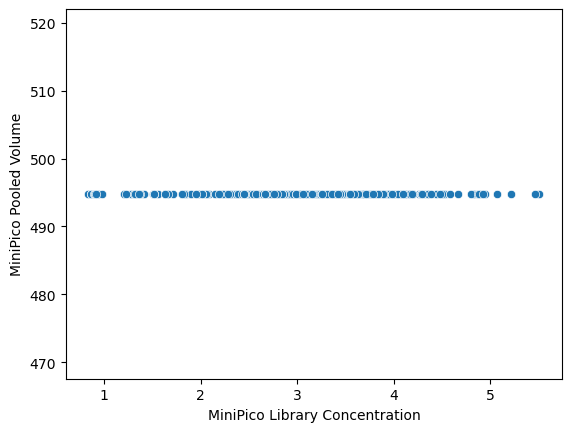

In [71]:
vols = make_2D_array(plate_df, data_col='MiniPico Pooled Volume', well_col=well_col).astype(float)
sns.scatterplot(x='MiniPico Library Concentration', y='MiniPico Pooled Volume',data=plate_df)

### Part 3 of 4, Step 5 of 7: Write plate dataframe to file

We want to keep all that useful information together in one place so that
it can be easily parsed later. 

In [72]:
plate_df['sample sheet Sample_ID'] = \
    plate_df[PM_SAMPLE_KEY].map(bcl_scrub_name)
plate_df['barcode_id'] = plate_df['i5 name']
plate_df.head()

,Sample,Col,Compressed Plate Name,Date,Plate Position,Project Abbreviation,Project Name,Project Plate,RackID,Row,...,i5 plate,i5 well_row,i5 well_col,barcode_set,MiniPico Library DNA Concentration,MiniPico Library Concentration,Input DNA,MiniPico Pooled Volume,sample sheet Sample_ID,barcode_id
0,41B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,A,...,TellSeq_Barcode_Plate_1,A,1,1,0.566,1.715152,7.495680,494.791667,41B_Month6_1,C501
1,43B.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,3,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_18_diluted,plate_3,A,...,TellSeq_Barcode_Plate_1,A,1,3,0.513,1.554545,7.502390,494.791667,43B_Month6_1,C501
2,41B.Month6.20,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,B,...,TellSeq_Barcode_Plate_1,M,1,1,0.831,2.518182,7.494180,494.791667,41B_Month6_20,C507
3,43B.Month6.20,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,3,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_18_diluted,plate_3,B,...,TellSeq_Barcode_Plate_1,M,1,3,0.777,2.354545,7.494064,494.791667,43B_Month6_20,C507
4,41L.Month6.1,1,Celeste_Adaptation_12986_16_17_18_CHILD_15510_...,20230627,1,ADAPT,Celeste_Adaptation_12986,Celeste_Adaptation_12986_Plate_16,plate_1,C,...,TellSeq_Barcode_Plate_1,I,2,1,1.078,3.266667,7.488925,494.791667,41L_Month6_1,C521


In [73]:
# Write the sample info DataFrame as .txt
plate_df_fp = './test_output/QC/YYYY_MM_DD_Celeste_Adaptation_matrix_df.txt'

if os.path.isfile(plate_df_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [74]:
plate_df.to_csv(plate_df_fp, sep='\t')

### Part 3 of 4, Step 6 of 7: make equal volume pooling pick lists and write to files

In [75]:
# Determine the sample sheet type to make
expt_type = TELLSEQ_ABSQUANT_SHEET_TYPE if is_absquant(plate_df) \
    else TELLSEQ_METAG_SHEET_TYPE
expt_type

'tellseq_metag'

In [76]:
evp_picklist_fbase = './test_output/Indices/YYYY_MM_DD_Celeste_Adaptation_evp'

In [77]:
set_nums = plate_df['barcode_set'].unique()

def get_picklist_fp(picklist_fbase, set_id):
    return f"{picklist_fbase}_set_{set_id}.txt"
    

def get_picklist_set_fps(picklist_fbase, list_of_set_nums):
    return [get_picklist_fp(picklist_fbase, i) for i in list_of_set_nums]

evp_picklist_fps = get_picklist_set_fps(evp_picklist_fbase, set_nums)
for i_fp in evp_picklist_fps:
    if os.path.isfile(i_fp):
        print(f"Warning! This file exists already: {i_fp}.")

Warning! This file exists already: ./test_output/Indices/YYYY_MM_DD_Celeste_Adaptation_evp_set_1.txt.


In [78]:
lanes = [1]
for i in set_nums:
    i_plate_df = plate_df[plate_df['barcode_set'] == i].copy()
    i_vols = make_2D_array(i_plate_df, data_col='MiniPico Pooled Volume', 
                           well_col=well_col).astype(float)
    i_evp_picklist = \
        format_pooling_echo_pick_list(i_vols, max_vol_per_well=30000)
    
    i_evp_picklist_fp = get_picklist_fp(evp_picklist_fbase, i)       
    with open(i_evp_picklist_fp, 'w') as f:
        f.write(i_evp_picklist)
        
    # Extend the metadata dictionary with additional information
    i_metadata_dict_w_sample_context = make_sections_dict(
        i_plate_df, studies_info, expt_name,
        expt_type, SHEET_TYPE_VERSIONS[expt_type], BIOINFO_BASE)
    
    i_novaseq_sheet = make_sample_sheet(
        i_metadata_dict_w_sample_context, i_plate_df, 'NovaSeq6000', lanes)


ErrorMessage: The following projects need to be in the Data and Bioinformatics sections: CHILD_15510, Celeste_Marmoset_14577


ValueError: ErrorMessage: The following projects need to be in the Data and Bioinformatics sections: CHILD_15510, Celeste_Marmoset_14577

In [ ]:
!head {evp_picklist_fps[0]}

### Part 3 of 4, Step 7 of 7: Make sample sheets and write to files

This step takes the pooled sample information and writes Illumina sample 
sheets that can be given directly to the sequencing center.

`# TODO: is this true? I thought Sample Name was NOT bcl2fastq-compatible?`

bcl2fastq-compatible names will be in the **`Sample ID`** and **`Sample Name`** columns. The
original sample names will be in the **`Description`** column.

Modify **`lanes`** to indicate which lanes this pool will be sequenced on.

**Project Name** and **Project Plate** values will be placed in the 
**`Sample_Project`** and **`Sample_Name`** columns, respectively.

`bcl2fastq` requires *only* alphanumeric, hyphens, and underscore characters. 
We'll replace all non-those characters with underscores and add the 
bcl2fastq-compatible names to the DataFrame.

**`sequencer`** is important for making sure the i5 index is in the correct 
orientation for demultiplexing. `NovaSeq6000`, `HiSeq4000`, `HiSeq3000`, 
`NextSeq`, `MiniSeq`, and `iSeq` all require reverse-complemented i5 
index sequences. If you enter one of these exact strings in for `sequencer`, 
it will revcomp the i5 sequence for you.

`HiSeq2500`, `MiSeq`, `NovaSeqX`, and `NovaSeqXPlus` will NOT revcomp the 
i5 sequence. 

#### Make and save the iSeq sample sheet

In [ ]:
lanes = [1]
iseq_sheet = make_sample_sheet(metadata_dict_w_sample_context, 
                               plate_df, 'iSeq', lanes)

In [ ]:
# Write the iseq samplesheet as .csv
iseq_sample_sheet_fp = './test_output/SampleSheets/YYYY_MM_DD_Celeste_Adaptation_12986_16_17_18_21_matrix_samplesheet_iseq.csv'

if os.path.isfile(iseq_sample_sheet_fp):
    print("Warning! This file exists already.")

In [ ]:
with open(iseq_sample_sheet_fp,'w') as f:
    iseq_sheet.write(f)
    
!head -n 30 {iseq_sample_sheet_fp}
!echo ...
!tail -n 15 {iseq_sample_sheet_fp}

#### Make and save NovaSeq6000 sample sheet

In [ ]:
lanes = [1]
novaseq_sheet = make_sample_sheet(metadata_dict_w_sample_context, 
                                  plate_df, 'NovaSeq6000', lanes)

In [ ]:
# Write the novaseq samplesheet as .csv
novaseq_sample_sheet_fp = './test_output/SampleSheets/YYYY_MM_DD_Celeste_Adaptation_12986_16_17_18_21_matrix_samplesheet_novaseq.csv'

if os.path.isfile(novaseq_sample_sheet_fp):
    print("Warning! This file exists already.")

In [ ]:
with open(novaseq_sample_sheet_fp,'w') as f:
    novaseq_sheet.write(f)
    
!head -n 30 {novaseq_sample_sheet_fp}
!echo ...
!tail -n 15 {novaseq_sample_sheet_fp}

## Part 4 (of 4): Workflow for Read Distribution Summary and Pool Normalization

#### Part 4 of 4, Step 1 of 4: import and merge per_sample read distributions

Import tsv file(s) with read_counts from per_sample_fastq files and merge with growing plate_df


In [ ]:
# Enter paths to read counts file(s)
read_counts_fps = [
    './test_data/Demux/YYYY_MM_DD_Celeste_Adaptation_raw_counts.tsv',
    './test_data/Demux/YYYY_MM_DD_Celeste_Marmoset_raw_counts.tsv',
    './test_data/Demux/YYYY_MM_DD_Child_raw_counts.tsv',
]

In [ ]:
# Import reads counts from file to dataframes
CATEGORY_KEY = 'Category'
UNIQUE_READS_KEY = 'Unique Reads'
DUPLICATE_READS_KEY = 'Duplicate Reads'
read_counts_df = join_dfs_from_files(
    read_counts_fps, [CATEGORY_KEY, UNIQUE_READS_KEY, DUPLICATE_READS_KEY],
    unique_cols=[CATEGORY_KEY], 
    dtype={CATEGORY_KEY: str, UNIQUE_READS_KEY: int, DUPLICATE_READS_KEY: int})
    
trimmed_reads_mask = read_counts_df[CATEGORY_KEY].str.contains('trimmed')
raw_read_counts_df = read_counts_df.loc[~trimmed_reads_mask].copy()
filtered_read_counts_df = read_counts_df.loc[trimmed_reads_mask].copy()

##Can also import counts from Qiita per_sample_FASTQ summaries.  
# per_sample_fastq_counts_df = pd.read_csv('./test_data/Demux/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_per_sample_fastq.tsv',
#                                          sep='\t')

In [ ]:
# Merge read_counts_df with plate_df 
plate_df_w_reads = merge_read_counts(
    plate_df, raw_read_counts_df, 
    reads_column_name='Raw Reads')
plate_df_w_reads = merge_read_counts(
    plate_df_w_reads, filtered_read_counts_df, 
    reads_column_name='Filtered Reads')

# plate_df_w_reads = merge_read_counts(
#    plate_df_w_reads, per_sample_fastq_counts_fp,
#    reads_column_name='Qiita Reads')

plate_df_w_reads.head()

In [ ]:
reads_column = 'Raw Reads'

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# evenness plot
rmax = int(round(plate_df_w_reads[reads_column].max(),-2))
survival_df = pd.concat([read_survival(plate_df_w_reads.loc[plate_df_w_reads['Blank'] == True,
                                                            reads_column], label='Blanks',rmax=rmax),
                         read_survival(plate_df_w_reads.loc[plate_df_w_reads['Blank'] == False,
                                                            reads_column], label='Samples',rmax=rmax)])

ax3.set_xlabel(reads_column)
ax3.set_ylabel('Samples')
survival_df.plot(color = ['coral','steelblue'],ax=ax1)
ax1.set_xlabel(reads_column)
ax1.set_ylabel('Samples')

##Histogram
sns.histplot(plate_df_w_reads[reads_column],ax=ax3)

##Regressopm
sns.regplot(x="MiniPico Library DNA Concentration", y=reads_column, data=plate_df_w_reads, ax = ax2)

#Boxplot
sns.boxplot(x="Blank", y=reads_column, data=plate_df_w_reads, ax = ax4)
sns.stripplot(x="Blank", y=reads_column, data=plate_df_w_reads, ax = ax4,
              size=3,color='black',alpha=0.5)


plt.tight_layout()

#### Part 4 of 4, Step 2 of 4: Calculate iSeqnorm pooling volumes

In [ ]:
plate_df_normalized = calculate_iseqnorm_pooling_volumes(plate_df_w_reads,dynamic_range=5, normalization_column='Raw Reads')

In [ ]:
# visualize
vols = make_2D_array(plate_df_normalized, data_col='iSeq normpool volume', well_col=well_col).astype(float)
conc, vol = estimate_pool_conc_vol(plate_df_normalized['iSeq normpool volume'], plate_df_normalized['MiniPico Library Concentration'])
print("Pool concentration: {:.2f}".format(conc))
print("Pool volume: {:.2f}".format(vol))
with suppress(np.linalg.LinAlgError):
    plot_plate_vals(vols)

#### Part 4 of 4, Step 3 of 4: Estimate read depth

In [ ]:
#Plots estimate of read depth proportion, and returns a df with estimates. 
plate_df_normalized_with_estimates = estimate_read_depth(plate_df_normalized)

#### Part 4 of 4, Step 4 of 4: Make pooling picklist and write to a file

In [ ]:
iseqnormed_picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)

In [ ]:
# Write the picklist as .csv
iseqnormed_picklist_fp = './test_output/Pooling/YYYY_MM_DD_Celeste_Adaptation_16_17_18_21_iSeqnormpool.csv'

if os.path.isfile(iseqnormed_picklist_fp):
    print("Warning! This file exists already.")

In [ ]:
with open(iseqnormed_picklist_fp,'w') as f:
    f.write(iseqnormed_picklist)

!head {iseqnormed_picklist_fp}